(discrete_choice)=
# Discrete Choice and Random Utility Models

:::{post} June, 2023
:tags: categorical regression, generalized linear model, discrete choice, model expansion
:category: advanced, reference
:author: Nathaniel Forde
:::

:::{include} ../extra_installs.md
:::

In [1]:
import arviz as az
import numpy as np  # For vectorized math operations
import pandas as pd  # For file input/output
import pymc as pm
import pytensor.tensor as pt

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

## Discrete Choice Modelling: The Idea

Discrete choice modelling is related to the idea of a latent utility scale as discussed in {ref}`ordinal_regression`, but it generalises the idea to decision making. It posits that human decision making can be modelled as a function of latent/subjective utility measurements over a set of mutually exclusive alternatives. The theory states that any decision maker will go with the option that maximises their subjective utility, __and__ that utility can be modelled as a latent linear function of observable features of the world. 

The idea is perhaps most famously applied by Daniel McFadden in the 1970s to predict the market share accruing to transportation choices (i.e. car, rail, walking etc..) in California after the proposed introduction of BART light rail system. It's worth pausing on that point. The theory is one of micro level human decision making that has, in real applications, been scaled up to make broadly accurate macro level predictions. For more details we recommend {cite:t}`train2009`

We don't need to be too credulous either. This is merely a statistical model and success here is entirely dependent on the skill of modeller and the available measurements coupled with plausible theory. But it's worth noting the scale of the ambition underlying these models. The structure of the model encourages you to articulate your theory of the decision makers and the environment they inhabit. 

### The Data

In this example, we'll examine the technique of discrete choice modelling using a (i) heating system data set from the R `mlogit` package and (ii) repeat choice data set over cracker brands. We'll be pursuing a Bayesian approach to estimating the models rather than the MLE methodology reported in their vigenette. The first data set shows household choices over offers of heating systems in California.  The observations consist of single-family houses in California that were newly built and had central air-conditioning. Five types of systems are considered to have been possible:

 - gas central (gc),
 - gas room (gr),
 - electric central (ec),
 - electric room (er),
 - heat pump (hp).

The data set reports the installation `ic.alt` and operating costs `oc.alt` each household was faced with for each of the five alternatives with some broad demographic information about the household and crucially the choice `depvar`. This is what one choice scenario over the five alternative looks like in the data:


In [3]:
try:
    wide_heating_df = pd.read_csv("../data/heating_data_r.csv")
except:
    wide_heating_df = pd.read_csv(pm.get_data("heating_data_r.csv"))

wide_heating_df[wide_heating_df["idcase"] == 1]

idcase depvar  ic.gc   ic.gr  ic.ec   ic.er   ic.hp   oc.gc   oc.gr  \
0       1     gc  866.0  962.64  859.9  995.76  1135.5  199.69  151.72   

    oc.ec  oc.er   oc.hp  income  agehed  rooms  region  
0  553.34  505.6  237.88       7      25      6  ncostl

The core idea of these kinds of models is to conceive of this scenario as a choice over exhaustive options with attached latent utility. The utility ascribed to each option is viewed as a linear combination of the attributes for each option. The utility ascribed to each alternative drives the probability of choosing amongst each option. For each $j$ in all the alternatives $Alt = \{ gc, gr, ec, er, hp \}$ which is assumed to take a Gumbel distribution because this has a particularly nice mathematical property. 

$$ \mathbf{U} \sim Gumbel $$

$$ \begin{pmatrix}
u_{gc}   \\
u_{gr}   \\
u_{ec}   \\
u_{er}   \\
u_{hp}   \\
\end{pmatrix} =  \begin{pmatrix}
gc_{ic} & gc_{oc}  \\
gr_{ic} & gr_{oc}  \\
ec_{ic} & ec_{oc}  \\
er_{ic} & er_{oc}  \\
hp_{ic} & hp_{oc}  \\
\end{pmatrix} \begin{pmatrix}
\beta_{ic}   \\
\beta_{oc}   \\
\end{pmatrix}  $$

This assumption proves to be mathematically convenient because the difference between two Gumbel distributions can be modelled as a logistic function, meaning we can model a contrast difference among multiple alternatives with the softmax function. Details of the derivation can be found in {cite:t}`train2009`

$$ \text{softmax}(u)_{j} = \frac{\exp(u_{j})}{\sum_{q=1}^{J}\exp(u_{q})} $$

The model then assumes that decision maker chooses the option that maximises their subjective utility. The individual utility functions can be richly parameterised. When contants are included, one alternative's constant must be fixed at 0 in order to normalise the overall level of the constants. 

$$\begin{pmatrix}
u_{gc}   \\
u_{gr}   \\
u_{ec}   \\
u_{er}   \\
u_{hp}   \\
\end{pmatrix}
$$

With all these constraints applied we can build out conditional random utility model and it's hierarchical variants. Like nearly all subjects in statistics the precise vocabulary for the model specification is overloaded. The conditional logit parameters $\beta$
may be fixed at the level of the individual, but can vary across individuals and the alternatives `gc, gr, ec, er` too. In this manner we can compose an elaborate theory of how we expect drivers of subjective utility to change the market share amongst a set of competing goods.

### Digression on Data Formats

Discrete choice models are often estimated using a long-data format where each choice scenario is represented with a row per alternative ID and a binary flag denoting the chosen option in each scenario. This data format is recommended for estimating these kinds of models in `stan` and in `pylogit`. The reason for doing this is that once the columns `installation_costs` and `operating_costs` have been pivoted in this fashion it's easier to include them in matrix calculations. 



In [4]:
try:
    long_heating_df = pd.read_csv("../data/long_heating_data.csv")
except:
    long_heating_df = pd.read_csv(pm.get_data("long_heating_data.csv"))

columns = [c for c in long_heating_df.columns if c != "Unnamed: 0"]
long_heating_df[long_heating_df["idcase"] == 1][columns]

idcase  alt_id  choice depvar  income  agehed  rooms  region  \
0       1       1       1     gc       7      25      6  ncostl   
1       1       2       0     gc       7      25      6  ncostl   
2       1       3       0     gc       7      25      6  ncostl   
3       1       4       0     gc       7      25      6  ncostl   
4       1       5       0     gc       7      25      6  ncostl   

   installation_costs  operating_costs  
0              866.00           199.69  
1              962.64           151.72  
2              859.90           553.34  
3              995.76           505.60  
4             1135.50           237.88

## The Basic Model

We will show here how to incorporate the utility specifications in PyMC. PyMC is a nice interface for this kind of modelling because it can express the model quite cleanly following the natural mathematical expression for this system of equations. You can see in this simple model how we go about constructing equations for the utility measure of each alternative separately, and then stacking them together to create the input matrix for our softmax transform. 

Sampling: [beta_ic, beta_oc, y_cat]
Compiling...
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Compilation time = 0:00:01.806791
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:03.589848
Transforming variables...
Transformation time = 0:00:00.487455
Computing Log Likelihood...
Log Likelihood time = 0:00:00.660260
Sampling: [y_cat]


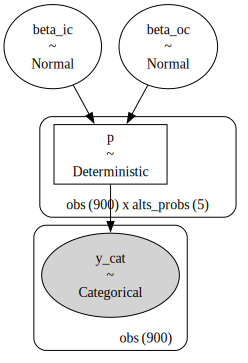

In [5]:
N = wide_heating_df.shape[0]
observed = pd.Categorical(wide_heating_df["depvar"]).codes
coords = {
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}

with pm.Model(coords=coords) as model_1:
    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)

    ## Construct Utility matrix and Pivot
    u0 = beta_ic * wide_heating_df["ic.ec"] + beta_oc * wide_heating_df["oc.ec"]
    u1 = beta_ic * wide_heating_df["ic.er"] + beta_oc * wide_heating_df["oc.er"]
    u2 = beta_ic * wide_heating_df["ic.gc"] + beta_oc * wide_heating_df["oc.gc"]
    u3 = beta_ic * wide_heating_df["ic.gr"] + beta_oc * wide_heating_df["oc.gr"]
    u4 = (
        beta_ic * wide_heating_df["ic.hp"] + beta_oc * wide_heating_df["oc.hp"]
    )  # np.zeros(N)  # Outside Good
    s = pm.math.stack([u0, u1, u2, u3, u4]).T

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m1 = pm.sample_prior_predictive()
    idata_m1.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=101)
    )
    idata_m1.extend(pm.sample_posterior_predictive(idata_m1))

pm.model_to_graphviz(model_1)

In [6]:
idata_m1

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [7]:
summaries = az.summary(idata_m1, var_names=["beta_ic", "beta_oc"])
summaries

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta_ic -0.006  0.0  -0.007   -0.006        0.0      0.0    3471.0    2790.0   
beta_oc -0.005  0.0  -0.005   -0.004        0.0      0.0    3971.0    2946.0   

         r_hat  
beta_ic    1.0  
beta_oc    1.0

In the `mlogit` vignette they report how the above model specification leads to inadequate parameter estimates. They note for instance that while the utility scale itself is hard to interpret the value of the ratio of the coefficients is often meaningful because when:

$$ U = \beta_{oc}oc + \beta_{ic}ic $$

then the marginal rate of substitution is just the ratio of the two beta coefficients. The relative importance of one component of the utility equation to another is an economically meaningful quantity even if the notion of subjective utility is itself unobservable. 

$$ dU = \beta_{ic} dic + \beta_{oc} doc = 0 \Rightarrow 
-\frac{dic}{doc}\mid_{dU=0}=\frac{\beta_{oc}}{\beta_{ic}}$$

Our parameter estimates differ slightly from the reported estimates, but we agree the model is inadequate. We will show a number of Bayesian model checks to demonstrate this fact, but the main call out is that the parameter values for installation costs should probably be negative. It's counter-intuitive that a $\beta_{ic}$ increase in price would increase the utility of generated by the installation even marginally as here. Although we might imagine that some kind of quality assurance comes with price which drives satisfaction with higher installation costs. The coefficient for repeat operating costs is negative as expected. Putting this issue aside for now, we'll show below how we can incorporate prior knowledge to adjust for this kind of conflicts with theory. 

But in any case, once we have a fitted model we can calculate the marginal rate of substitution as follows:


In [8]:
## marginal rate of substitution for a reduction in installation costs
post = az.extract(idata_m1)
substitution_rate = post["beta_oc"] / post["beta_ic"]
substitution_rate.mean().item()

0.7380233924649465

This statistic gives a view of the relative importance of the attributes which drive our utility measures. But being good Bayesians we actually want to calculate the posterior distribution for this statistic.

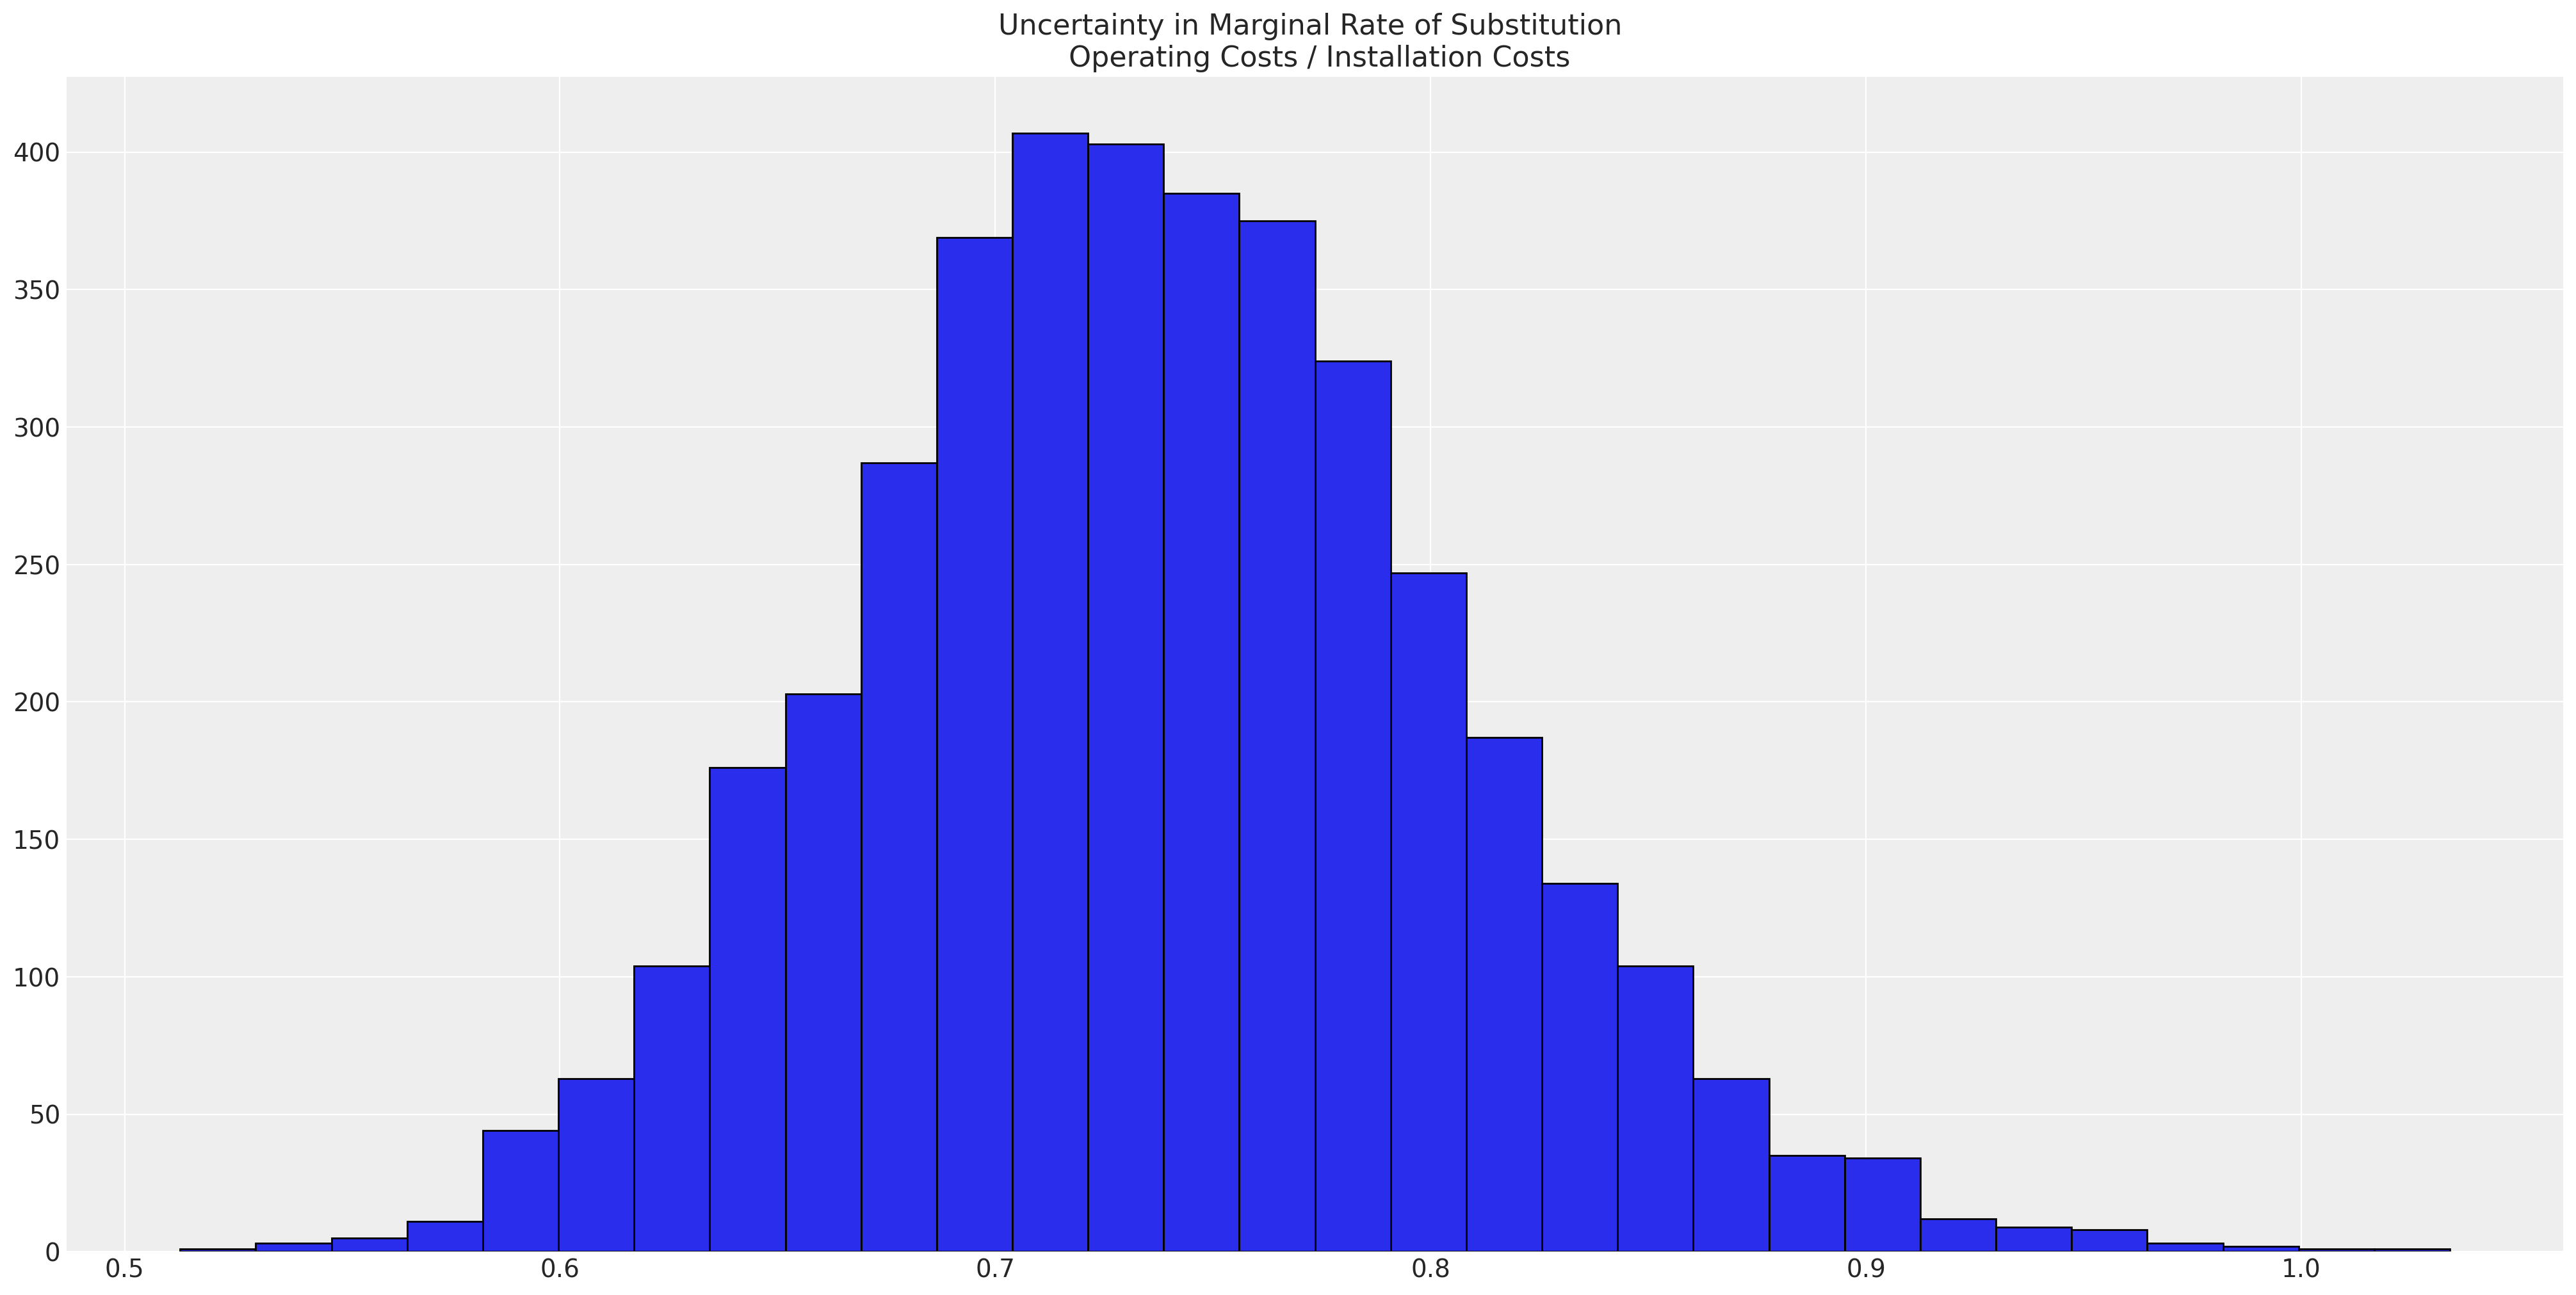

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.hist(
    substitution_rate,
    bins=30,
    ec="black",
)
ax.set_title("Uncertainty in Marginal Rate of Substitution \n Operating Costs / Installation Costs");

which suggests that there is almost twice the value accorded to the a unit reduction in recurring operating costs over the one-off installation costs. Whether this is remotely plausible is almost beside the point since the model does not even closely capture the data generating process. But it's worth repeating that the native scale of utility is not straightforwardly meaningful, but the ratio of the coefficients in the utility equations can be directly interpreted.  

To assess overall model adequacy we can rely on the posterior predictive checks to see if the model can recover an approximation to the data generating process.

In [10]:
idata_m1["posterior"]["p"].mean(dim=["chain", "draw", "obs"]).to_dataframe()["p"]

alts_probs
ec    0.104173
er    0.051373
gc    0.517023
gr    0.240261
hp    0.087170
Name: p, dtype: float64

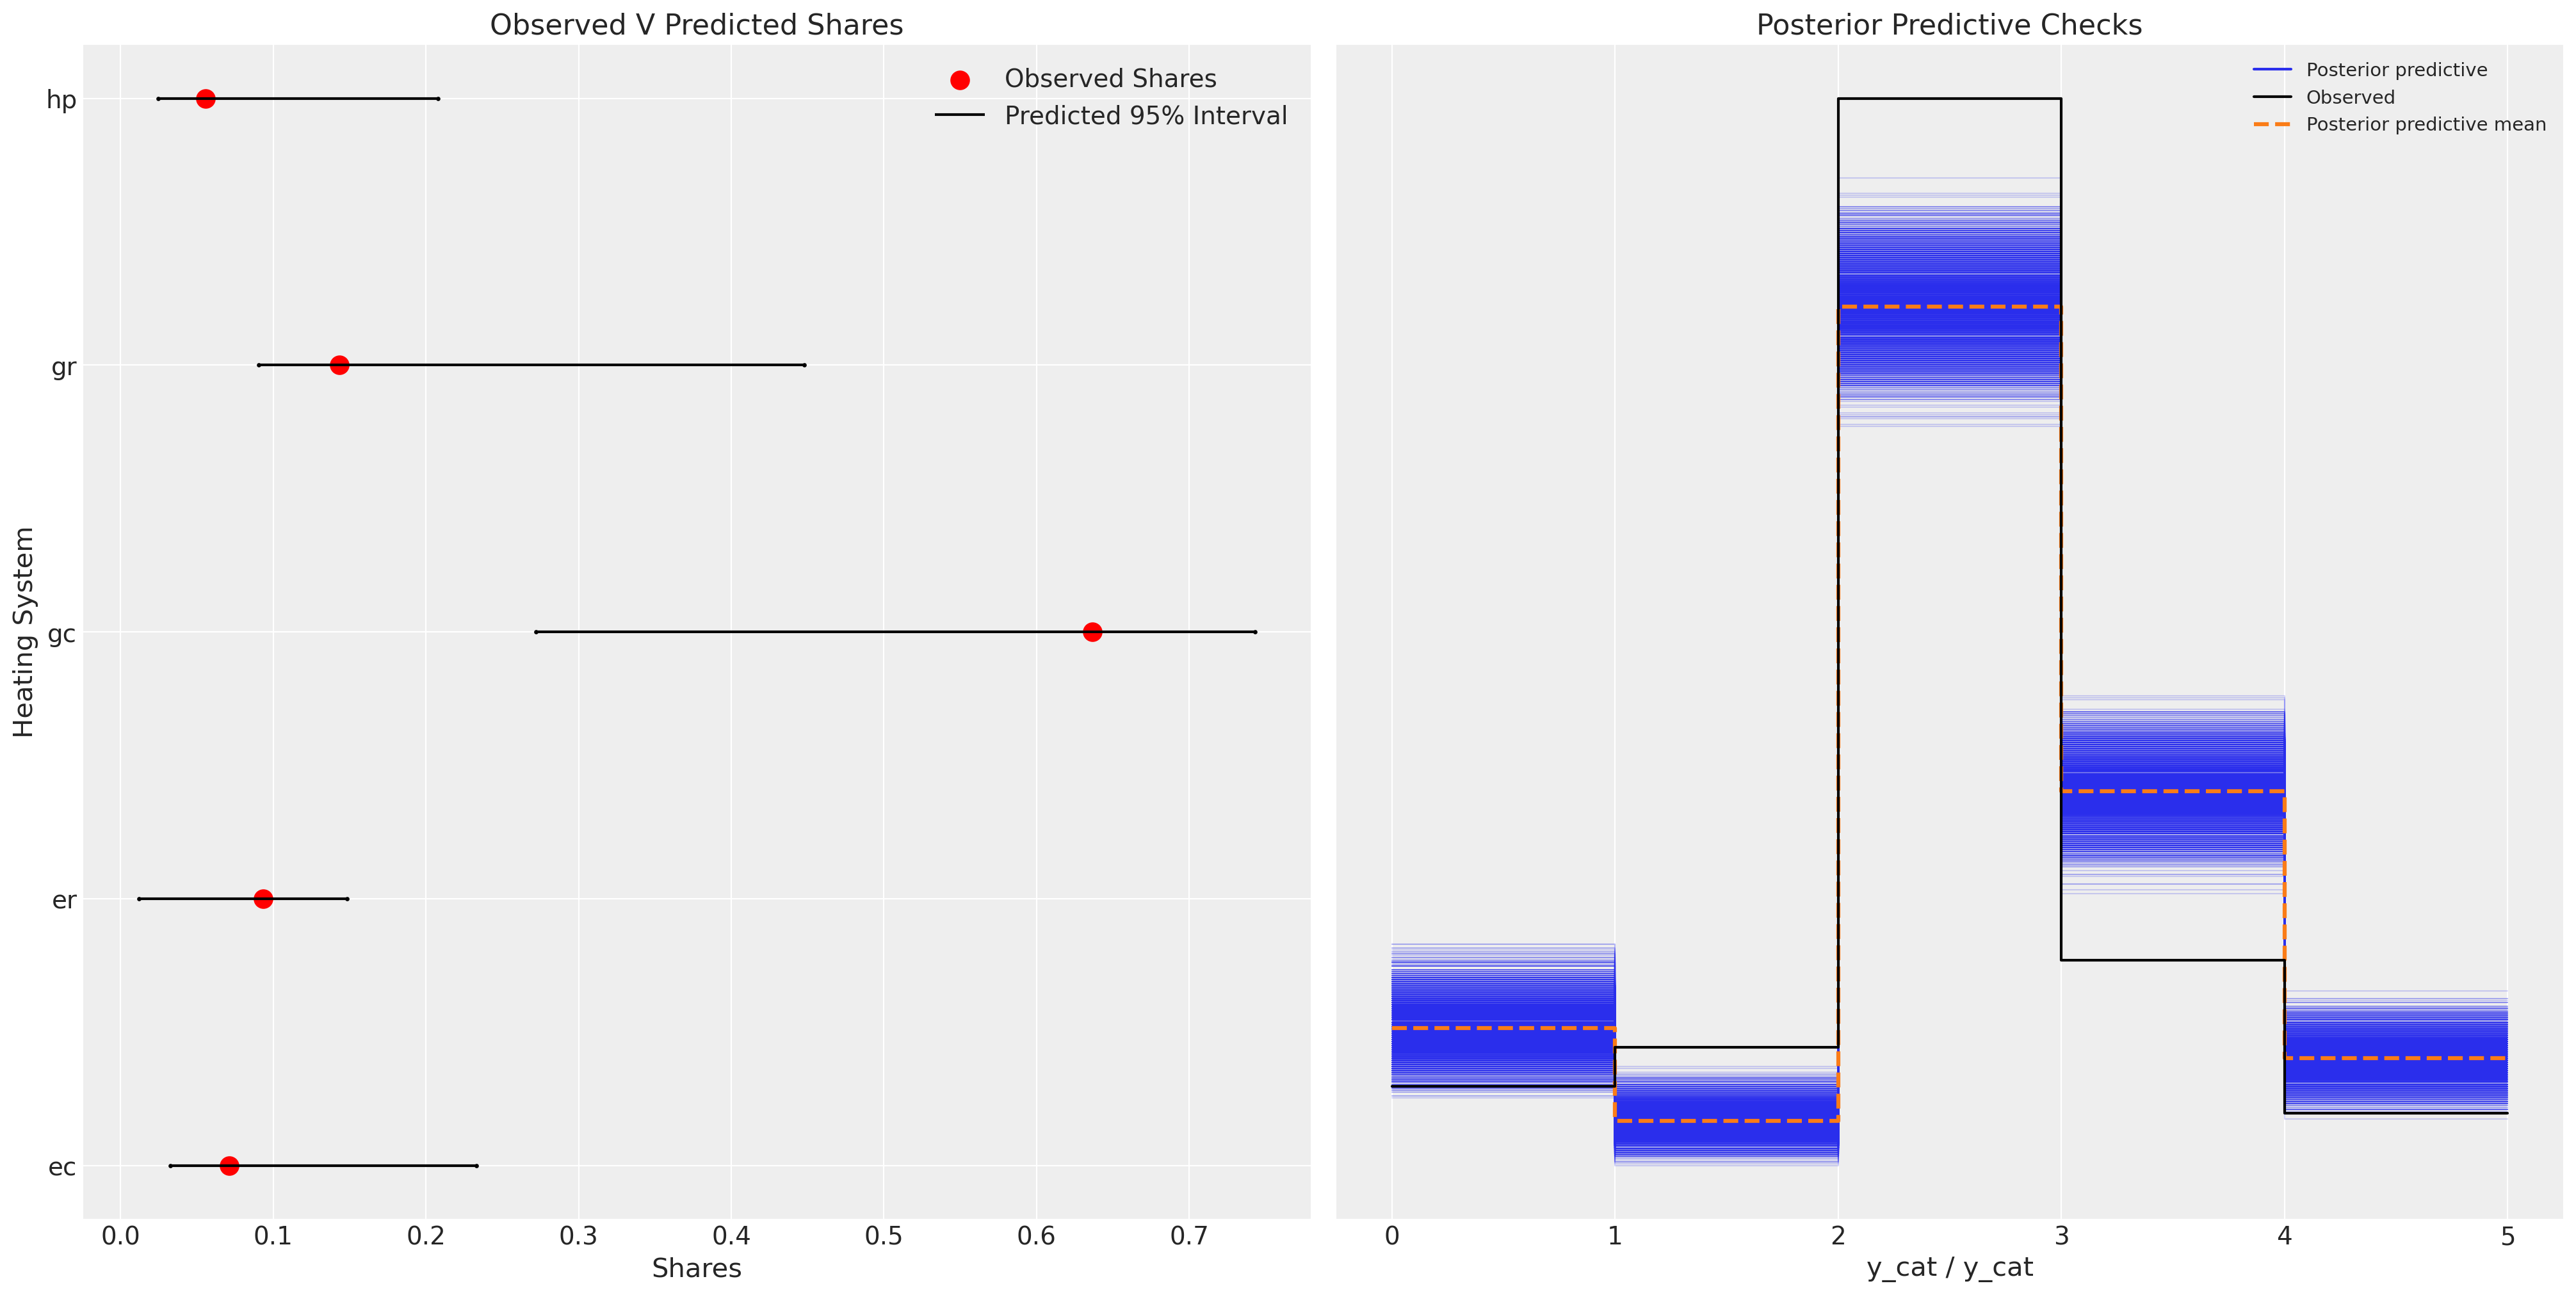

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax = axs[0]
counts = wide_heating_df.groupby("depvar")["idcase"].count()
predicted_shares = idata_m1["posterior"]["p"].mean(dim=["chain", "draw", "obs"])
ci_lb = idata_m1["posterior"]["p"].quantile(0.025, dim=["chain", "draw", "obs"])
ci_ub = idata_m1["posterior"]["p"].quantile(0.975, dim=["chain", "draw", "obs"])
ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    counts / counts.sum(),
    ["ec", "er", "gc", "gr", "hp"],
    label="Observed Shares",
    color="red",
    s=100,
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"], ci_lb, ci_ub, label="Predicted 95% Interval", color="black"
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m1, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Heating System");

We can see here that the model is fairly inadequate, and fails quite dramatically to recapture the posterior predictive distribution. 

## Improved Model: Adding Alternative Specific Intercepts

We can address some of the issues with the prior model specification by adding intercept terms for each of the unique alternatives `gr, gc, ec, er`. These terms will absorb some of the error seen in the last model by allowing us to control some of the heterogenity of utility measures across products. 

Sampling: [alpha, beta_ic, beta_oc, y_cat]
Compiling...
Compilation time = 0:00:02.168994
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:15.558693
Transforming variables...
Transformation time = 0:00:00.521186
Computing Log Likelihood...
Log Likelihood time = 0:00:00.672748
Sampling: [y_cat]


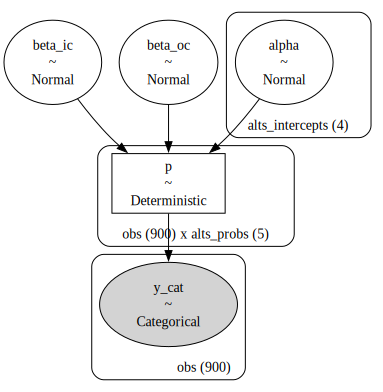

In [12]:
N = wide_heating_df.shape[0]
observed = pd.Categorical(wide_heating_df["depvar"]).codes

coords = {
    "alts_intercepts": ["ec", "er", "gc", "gr"],
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}
with pm.Model(coords=coords) as model_2:
    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)
    alphas = pm.Normal("alpha", 0, 1, dims="alts_intercepts")

    ## Construct Utility matrix and Pivot using an intercept per alternative
    u0 = alphas[0] + beta_ic * wide_heating_df["ic.ec"] + beta_oc * wide_heating_df["oc.ec"]
    u1 = alphas[1] + beta_ic * wide_heating_df["ic.er"] + beta_oc * wide_heating_df["oc.er"]
    u2 = alphas[2] + beta_ic * wide_heating_df["ic.gc"] + beta_oc * wide_heating_df["oc.gc"]
    u3 = alphas[3] + beta_ic * wide_heating_df["ic.gr"] + beta_oc * wide_heating_df["oc.gr"]
    u4 = (
        0 + beta_ic * wide_heating_df["ic.hp"] + beta_oc * wide_heating_df["oc.hp"]
    )  # Make one constant zero
    s = pm.math.stack([u0, u1, u2, u3, u4]).T

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m2 = pm.sample_prior_predictive()
    idata_m2.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=103)
    )
    idata_m2.extend(pm.sample_posterior_predictive(idata_m2))


pm.model_to_graphviz(model_2)

In [13]:
az.summary(idata_m2, var_names=["beta_ic", "beta_oc", "alpha"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_ic   -0.002  0.001  -0.003   -0.001      0.000    0.000    2607.0   
beta_oc   -0.006  0.001  -0.008   -0.003      0.000    0.000    1259.0   
alpha[ec]  1.179  0.379   0.491    1.900      0.011    0.008    1291.0   
alpha[er]  1.481  0.310   0.913    2.080      0.009    0.006    1271.0   
alpha[gc]  1.602  0.211   1.184    1.989      0.005    0.004    1467.0   
alpha[gr]  0.266  0.191  -0.085    0.634      0.005    0.004    1379.0   

           ess_tail  r_hat  
beta_ic      2813.0    1.0  
beta_oc      1520.0    1.0  
alpha[ec]    1583.0    1.0  
alpha[er]    1607.0    1.0  
alpha[gc]    1402.0    1.0  
alpha[gr]    1507.0    1.0

We can see now how this model performs much better in capturing aspects of the data generating process. 

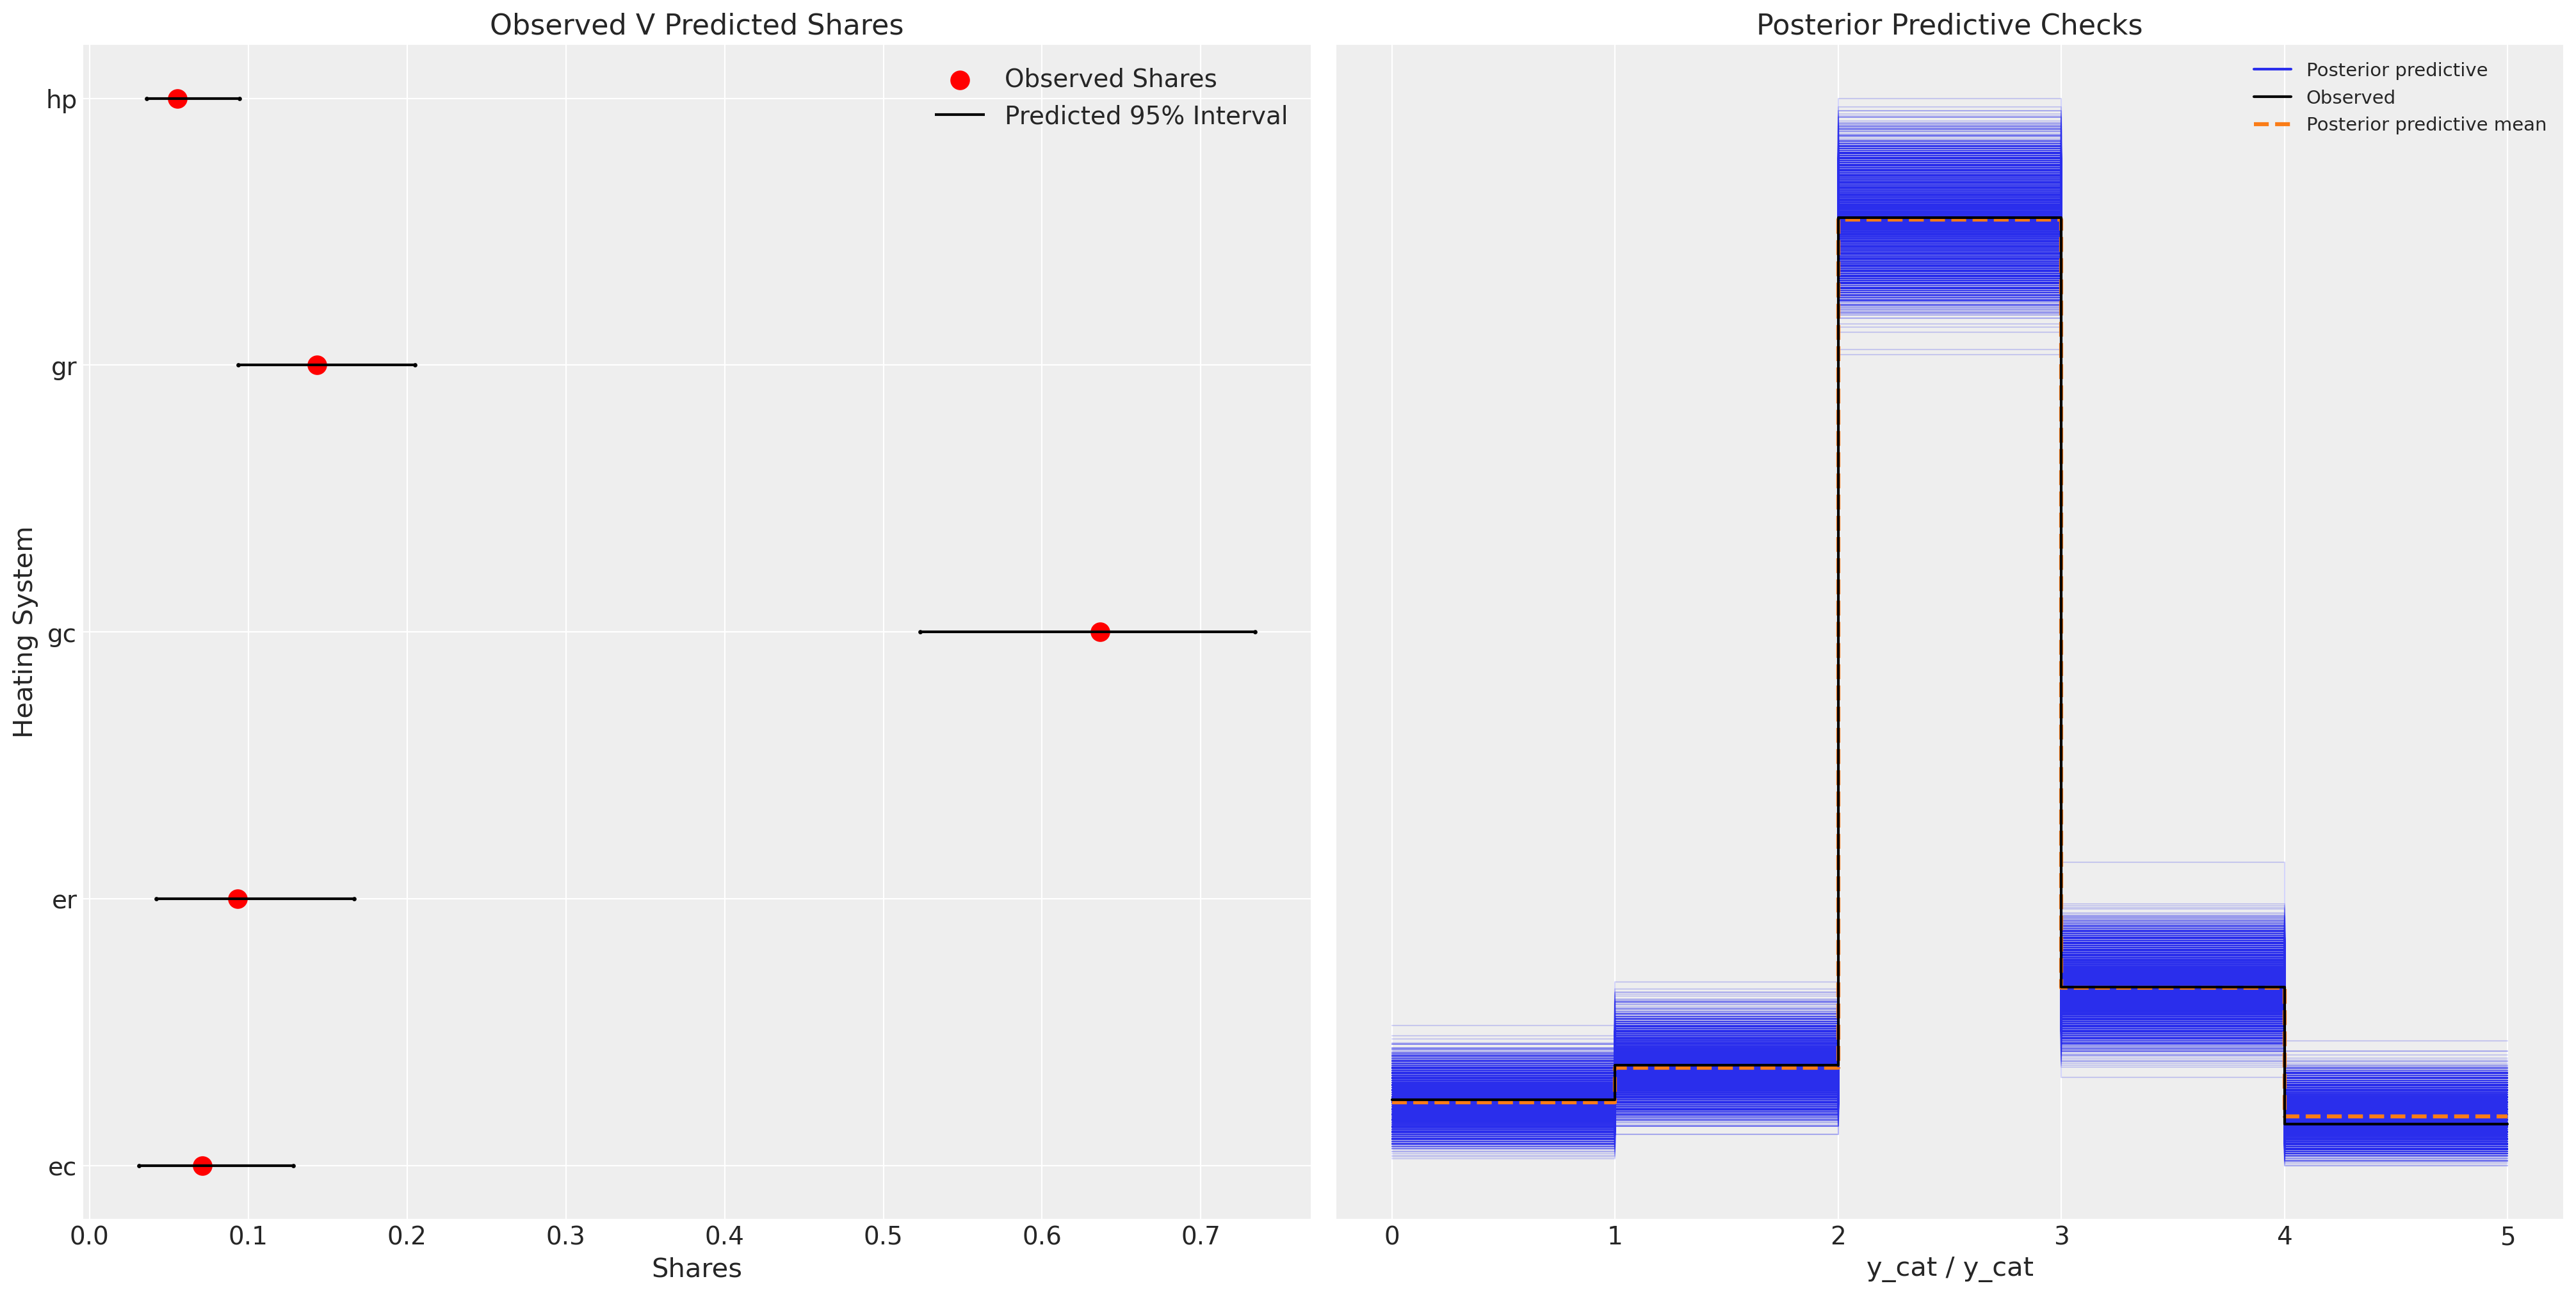

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax = axs[0]
counts = wide_heating_df.groupby("depvar")["idcase"].count()
predicted_shares = idata_m2["posterior"]["p"].mean(dim=["chain", "draw", "obs"])
ci_lb = idata_m2["posterior"]["p"].quantile(0.025, dim=["chain", "draw", "obs"])
ci_ub = idata_m2["posterior"]["p"].quantile(0.975, dim=["chain", "draw", "obs"])

ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    counts / counts.sum(),
    ["ec", "er", "gc", "gr", "hp"],
    label="Observed Shares",
    color="red",
    s=100,
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"], ci_lb, ci_ub, label="Predicted 95% Interval", color="black"
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m2, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Heating System");

This model represents a substantial improvement. 

## Experimental Model: Adding Correlation Structure

We might think that there is a correlation among the alternative goods that we should capture too. We can capture those effects in so far as they exist by placing a multvariate normal prior on the intercepts, (or alternatively the beta parameters). In addition we add information about how the effect of income influences the utility accorded to each alternative. 

Sampling: [alpha, beta_ic, beta_income, beta_oc, chol, y_cat]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:04.533953
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:30.042792
Transforming variables...
Transformation time =  0:00:00.594139
Computing Log Likelihood...


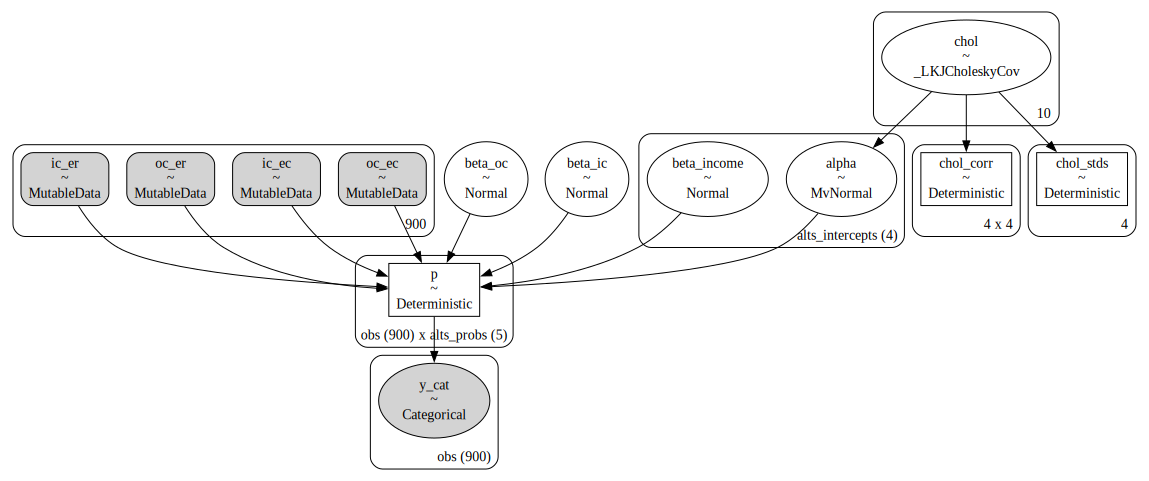

In [15]:
coords = {
    "alts_intercepts": ["ec", "er", "gc", "gr"],
    "alts_probs": ["ec", "er", "gc", "gr", "hp"],
    "obs": range(N),
}
with pm.Model(coords=coords) as model_3:
    ## Add data to experiment with changes later.
    ic_ec = pm.MutableData("ic_ec", wide_heating_df["ic.ec"])
    oc_ec = pm.MutableData("oc_ec", wide_heating_df["oc.ec"])
    ic_er = pm.MutableData("ic_er", wide_heating_df["ic.er"])
    oc_er = pm.MutableData("oc_er", wide_heating_df["oc.er"])

    beta_ic = pm.Normal("beta_ic", 0, 1)
    beta_oc = pm.Normal("beta_oc", 0, 1)
    beta_income = pm.Normal("beta_income", 0, 1, dims="alts_intercepts")
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=4, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=4)
    )
    alphas = pm.MvNormal("alpha", mu=0, chol=chol, dims="alts_intercepts")

    u0 = alphas[0] + beta_ic * ic_ec + beta_oc * oc_ec + beta_income[0] * wide_heating_df["income"]
    u1 = alphas[1] + beta_ic * ic_er + beta_oc * oc_er + beta_income[1] * wide_heating_df["income"]
    u2 = (
        alphas[2]
        + beta_ic * wide_heating_df["ic.gc"]
        + beta_oc * wide_heating_df["oc.gc"]
        + beta_income[2] * wide_heating_df["income"]
    )
    u3 = (
        alphas[3]
        + beta_ic * wide_heating_df["ic.gr"]
        + beta_oc * wide_heating_df["oc.gr"]
        + beta_income[3] * wide_heating_df["income"]
    )
    u4 = np.zeros(N)  # pivot
    s = pm.math.stack([u0, u1, u2, u3, u4]).T

    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m3 = pm.sample_prior_predictive()
    idata_m3.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=100)
    )
    idata_m3.extend(pm.sample_posterior_predictive(idata_m3))


pm.model_to_graphviz(model_3)

Plotting the model fit we see a similar story.The model predictive performance is not drastically improved and we have added some complexity to the model. This extra complexity ought to be penalised in model assessment metrics such as AIC and WAIC. But often the correlation amongst products are some of the features of interest, independent of issues of historic predictions.

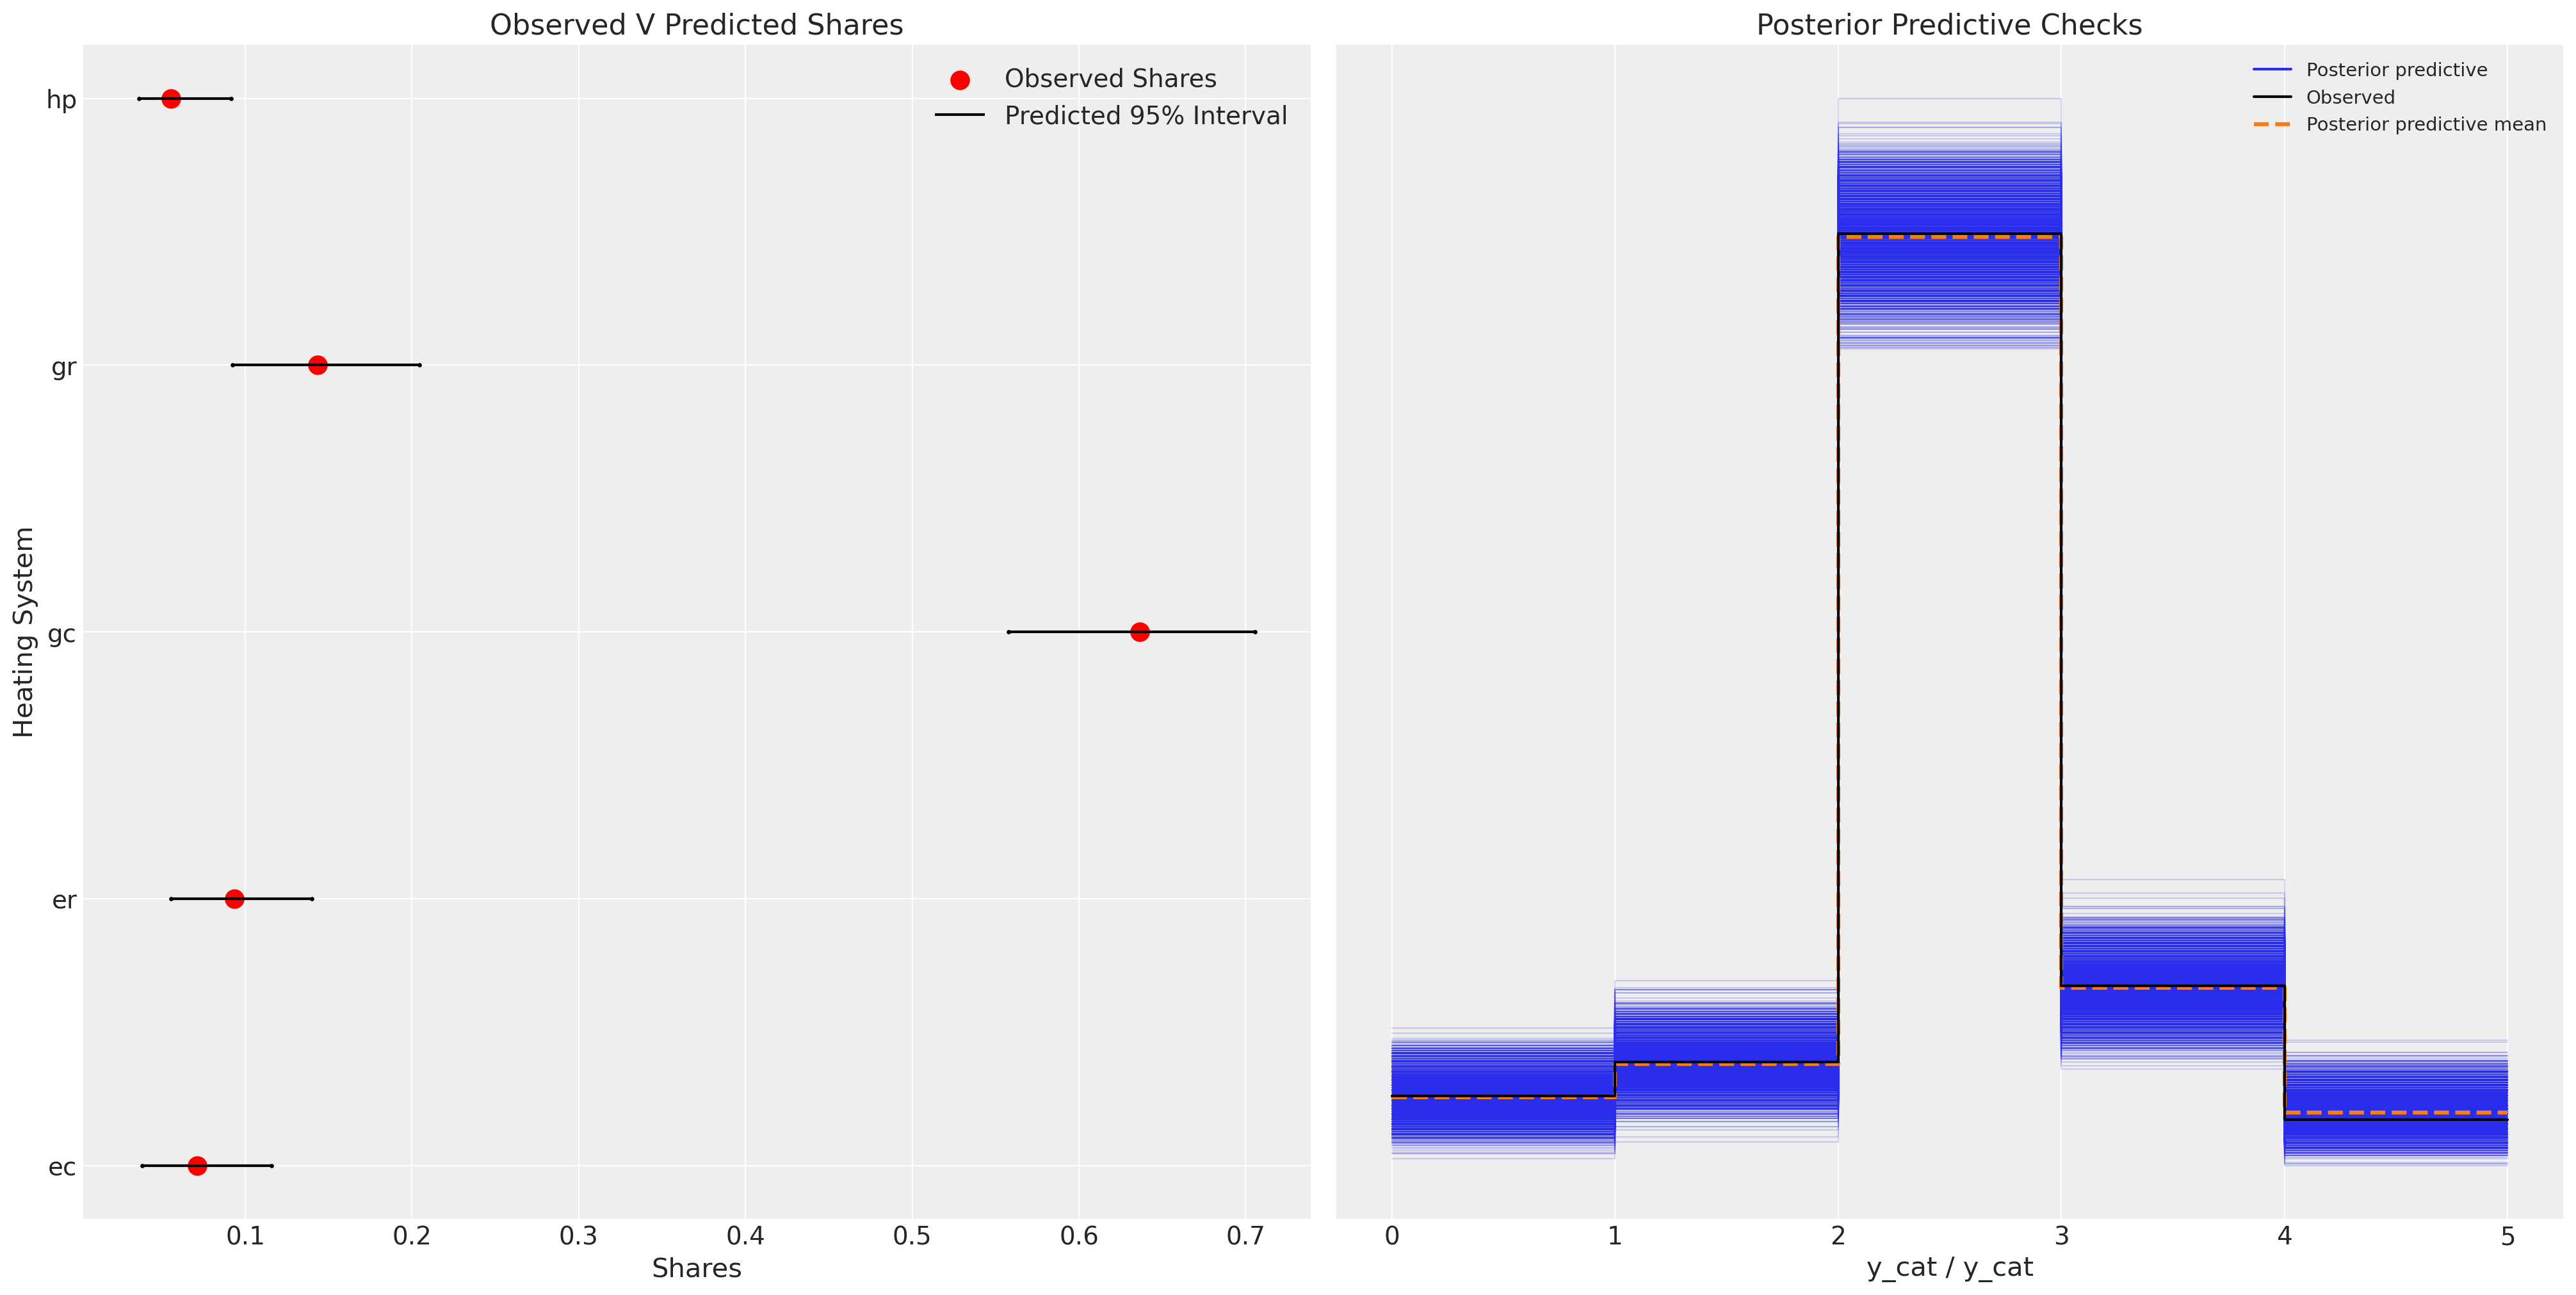

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax = axs[0]
counts = wide_heating_df.groupby("depvar")["idcase"].count()
predicted_shares = idata_m3["posterior"]["p"].mean(dim=["chain", "draw", "obs"])
ci_lb = idata_m3["posterior"]["p"].quantile(0.025, dim=["chain", "draw", "obs"])
ci_ub = idata_m3["posterior"]["p"].quantile(0.975, dim=["chain", "draw", "obs"])

ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    counts / counts.sum(),
    ["ec", "er", "gc", "gr", "hp"],
    label="Observed Shares",
    color="red",
    s=100,
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"], ci_lb, ci_ub, label="Predicted 95% Interval", color="black"
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m3, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Heating System");

That extra complexity can be informative, and the degree of relationship amongst the alternative products will inform the substitution patterns under policy changes. Also, note how under this model specification the parameter for `beta_ic` has a expected value of 0. Suggestive perhaps of a resignation towards the reality of installation costs that doesn't change the  utility metric one way or other after a decision to purchase.

In [17]:
az.summary(
    idata_m3, var_names=["beta_income", "beta_ic", "beta_oc", "alpha", "chol_corr"], round_to=4
)

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_income[ec]  0.0971  0.1074 -0.1025   0.3046     0.0035   0.0025   
beta_income[er]  0.0655  0.1047 -0.1187   0.2695     0.0036   0.0025   
beta_income[gc]  0.0673  0.0867 -0.1058   0.2202     0.0032   0.0023   
beta_income[gr] -0.0318  0.0977 -0.2220   0.1441     0.0034   0.0024   
beta_ic          0.0004  0.0007 -0.0009   0.0016     0.0000   0.0000   
beta_oc         -0.0035  0.0015 -0.0064  -0.0007     0.0000   0.0000   
alpha[ec]        1.0354  1.0479 -0.4211   3.0541     0.0470   0.0333   
alpha[er]        1.2391  1.0751 -0.3175   3.2426     0.0507   0.0358   
alpha[gc]        2.3718  0.7613  1.1220   3.7710     0.0366   0.0259   
alpha[gr]        1.2014  0.8524 -0.0952   2.8006     0.0402   0.0284   
chol_corr[0, 0]  1.0000  0.0000  1.0000   1.0000     0.0000   0.0000   
chol_corr[0, 1]  0.1184  0.3671 -0.5402   0.7923     0.0074   0.0062   
chol_corr[0, 2]  0.1427  0.3705 -0.5480   0.7769     0.0093   0.0066   
chol_corr[0, 3]  0.1157  0.3753 -0.5676   0.7683     0.0079   0.0056   
chol_corr[1, 0]  0.1184  0.3671 -0.5402   0.7923     0.0074   0.0062   
chol_corr[1, 1]  1.0000  0.0000  1.0000   1.0000     0.0000   0.0000   
chol_corr[1, 2]  0.1675  0.3483 -0.4430   0.8095     0.0079   0.0056   
chol_corr[1, 3]  0.1526  0.3561 -0.4722   0.7963     0.0070   0.0050   
chol_corr[2, 0]  0.1427  0.3705 -0.5480   0.7769     0.0093   0.0066   
chol_corr[2, 1]  0.1675  0.3483 -0.4430   0.8095     0.0079   0.0056   
chol_corr[2, 2]  1.0000  0.0000  1.0000   1.0000     0.0000   0.0000   
chol_corr[2, 3]  0.1757  0.3411 -0.4384   0.7867     0.0071   0.0051   
chol_corr[3, 0]  0.1157  0.3753 -0.5676   0.7683     0.0079   0.0056   
chol_corr[3, 1]  0.1526  0.3561 -0.4722   0.7963     0.0070   0.0050   
chol_corr[3, 2]  0.1757  0.3411 -0.4384   0.7867     0.0071   0.0051   
chol_corr[3, 3]  1.0000  0.0000  1.0000   1.0000     0.0000   0.0000   

                  ess_bulk   ess_tail   r_hat  
beta_income[ec]   936.3265  1900.0530  1.0033  
beta_income[er]   839.1058  1613.9147  1.0017  
beta_income[gc]   722.9224  1321.0255  1.0028  
beta_income[gr]   807.8161  1624.6096  1.0020  
beta_ic           752.9909   914.0799  1.0019  
beta_oc          1436.0405  2066.3187  1.0015  
alpha[ec]         520.2449  1178.1694  1.0063  
alpha[er]         441.6820   991.4928  1.0064  
alpha[gc]         414.8905   699.3486  1.0073  
alpha[gr]         442.3913  1198.3044  1.0053  
chol_corr[0, 0]  4000.0000  4000.0000     NaN  
chol_corr[0, 1]  2518.0052  2043.9328  1.0015  
chol_corr[0, 2]  1673.7845  1975.7307  1.0020  
chol_corr[0, 3]  2319.4753  2119.7780  1.0012  
chol_corr[1, 0]  2518.0052  2043.9328  1.0015  
chol_corr[1, 1]  4239.6296  4000.0000  0.9996  
chol_corr[1, 2]  1978.9399  1538.2851  1.0011  
chol_corr[1, 3]  2595.1991  3126.5524  1.0014  
chol_corr[2, 0]  1673.7845  1975.7307  1.0020  
chol_corr[2, 1]  1978.9399  1538.2851  1.0011  
chol_corr[2, 2]  3929.0431  4000.0000  1.0007  
chol_corr[2, 3]  2260.6724  2564.2728  1.0017  
chol_corr[3, 0]  2319.4753  2119.7780  1.0012  
chol_corr[3, 1]  2595.1991  3126.5524  1.0014  
chol_corr[3, 2]  2260.6724  2564.2728  1.0017  
chol_corr[3, 3]  3954.4789  3702.0363  1.0001

In this model we see that the marginal rate of substitution shows that an increase of one dollar for the operating costs is almost 17 times more impactful on the utility calculus than a similar increase in installation costs. Which makes sense in so far as we can expect the installation costs to be a one-off expense we're pretty resigned to. 

In [18]:
post = az.extract(idata_m3)
substitution_rate = post["beta_oc"] / post["beta_ic"]
substitution_rate.mean().item()

17.581376035151784

### Market Inteventions and Predicting Market Share

We can additionally use these kinds of models to predict market share under interventions where we change the price offering.

In [19]:
with model_3:
    # update values of predictors with new 20% price increase in operating costs for electrical options
    pm.set_data({"oc_ec": wide_heating_df["oc.ec"] * 1.2, "oc_er": wide_heating_df["oc.er"] * 1.2})
    # use the updated values and predict outcomes and probabilities:
    idata_new_policy = pm.sample_posterior_predictive(
        idata_m3,
        var_names=["p", "y_cat"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=False,
        random_seed=100,
    )

idata_new_policy

Inference data with groups:
	> predictions
	> predictions_constant_data

In [20]:
idata_new_policy["predictions"]["p"].mean(dim=["chain", "draw", "obs"])

<xarray.DataArray 'p' (alts_probs: 5)>
array([0.05383866, 0.07239016, 0.66253495, 0.1482966 , 0.06293963])
Coordinates:
  * alts_probs  (alts_probs) <U2 'ec' 'er' 'gc' 'gr' 'hp'

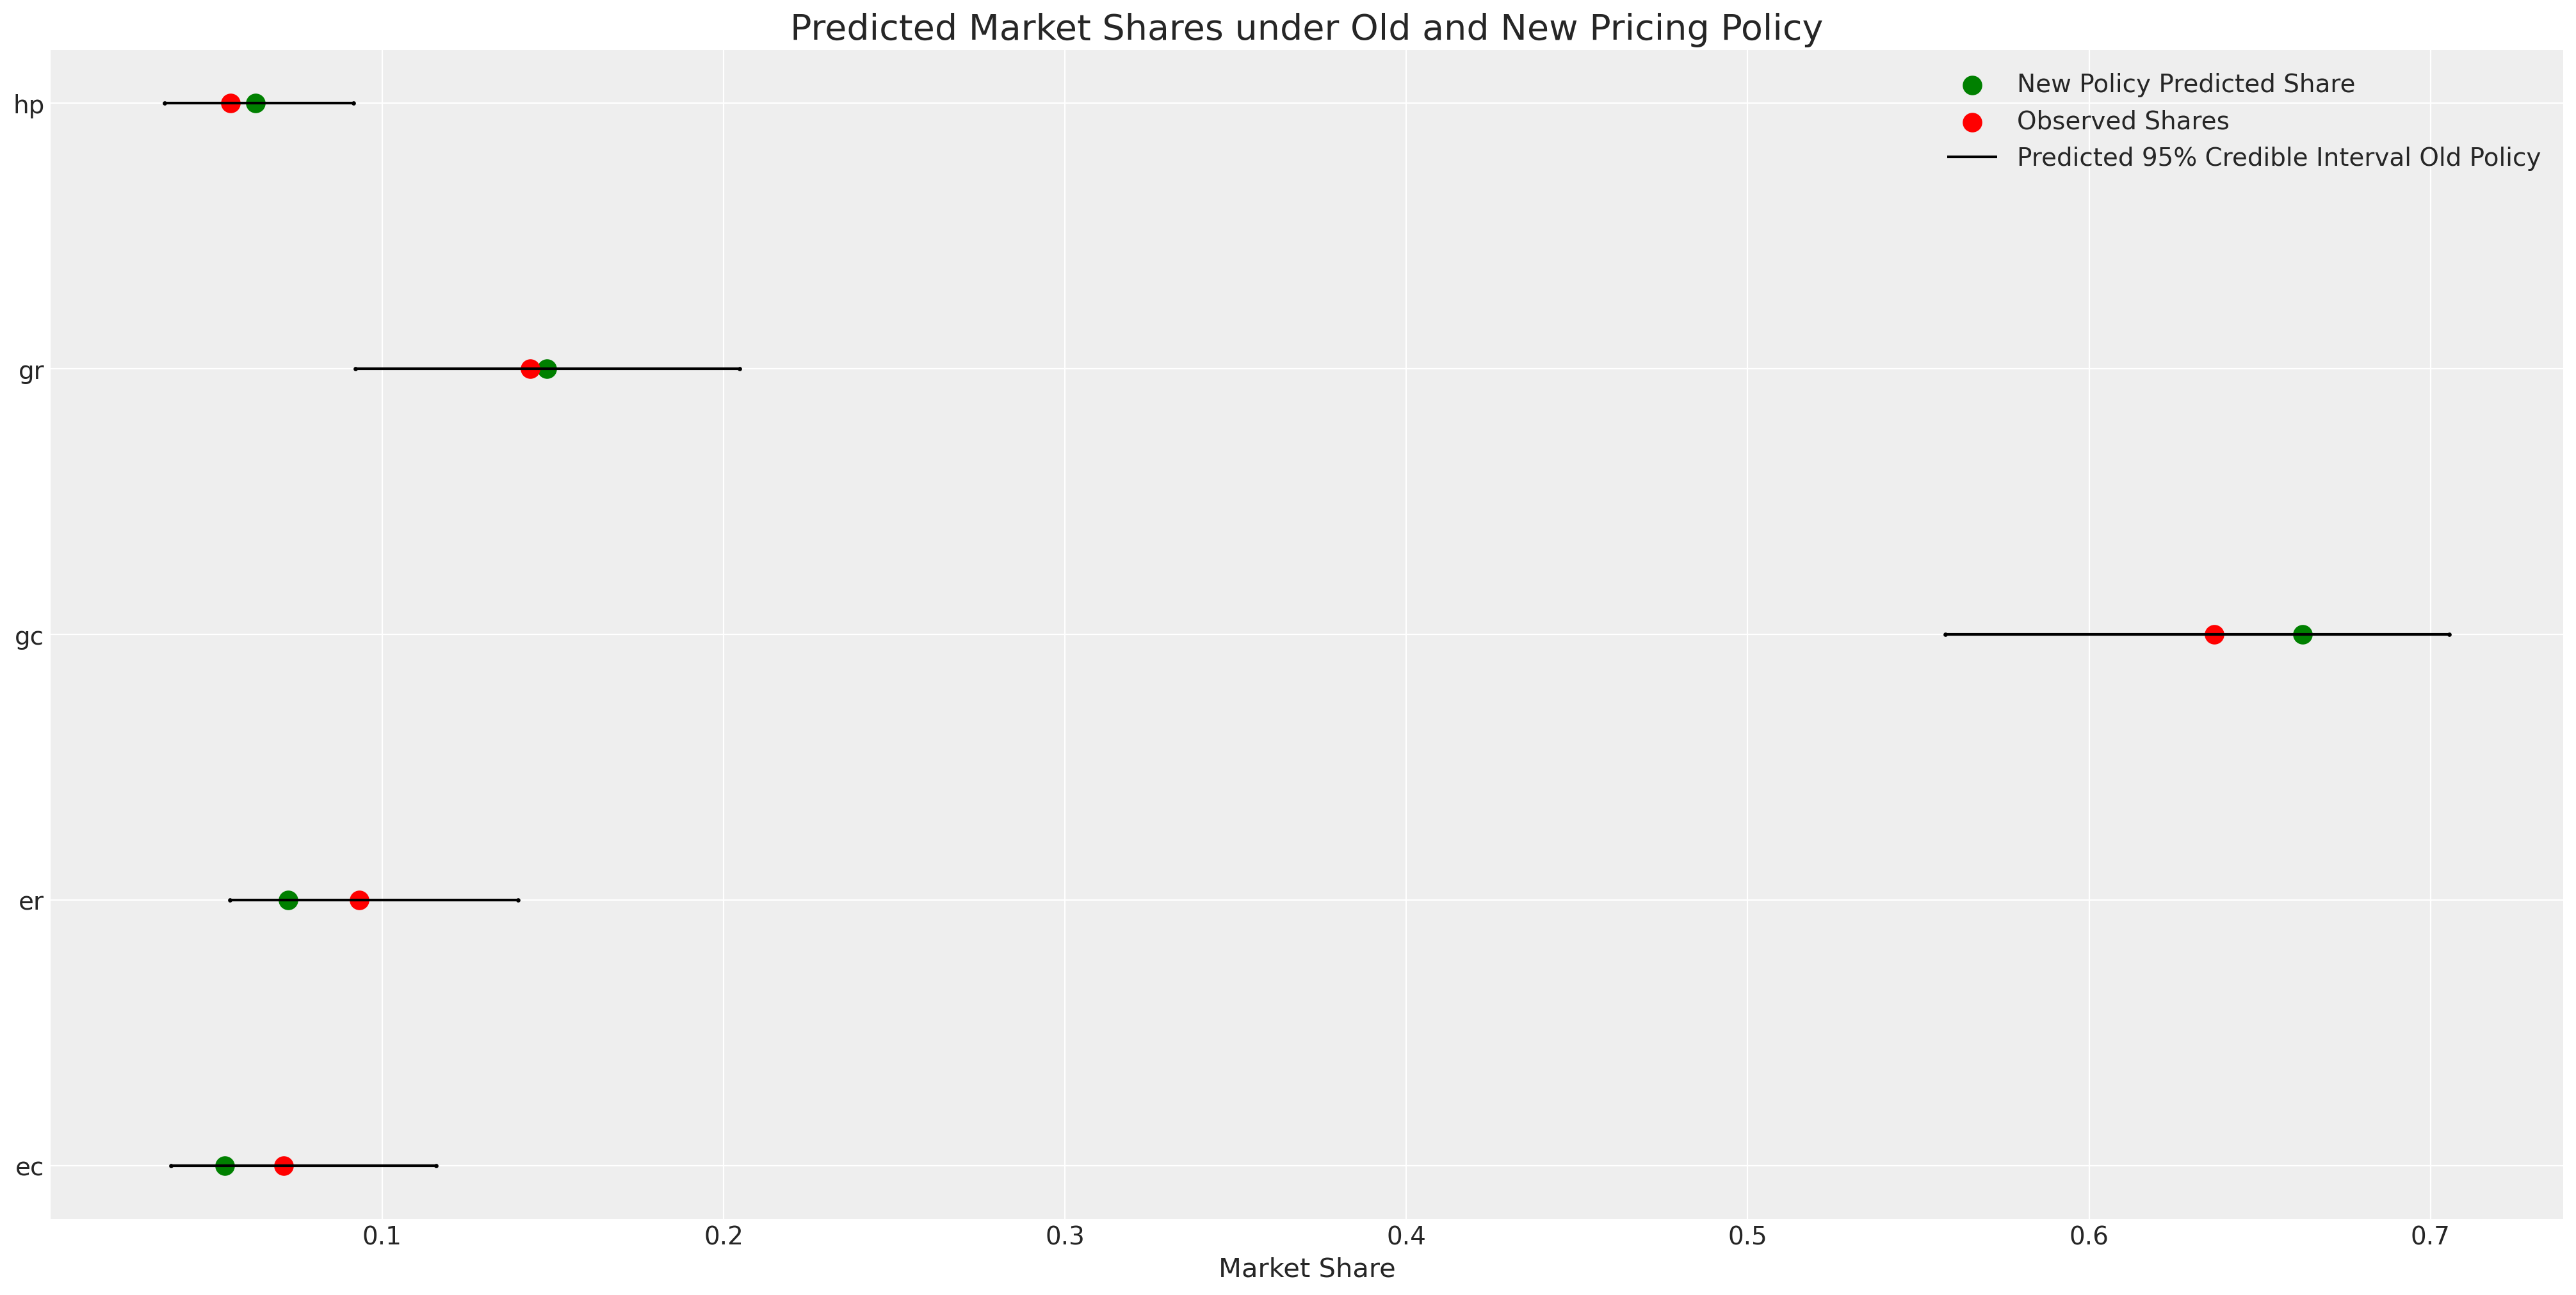

In [21]:
fig, ax = plt.subplots(1, figsize=(20, 10))
counts = wide_heating_df.groupby("depvar")["idcase"].count()
new_predictions = idata_new_policy["predictions"]["p"].mean(dim=["chain", "draw", "obs"]).values
ci_lb = idata_m3["posterior"]["p"].quantile(0.025, dim=["chain", "draw", "obs"])
ci_ub = idata_m3["posterior"]["p"].quantile(0.975, dim=["chain", "draw", "obs"])
ax.scatter(ci_lb, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(ci_ub, ["ec", "er", "gc", "gr", "hp"], color="k", s=2)
ax.scatter(
    new_predictions,
    ["ec", "er", "gc", "gr", "hp"],
    color="green",
    label="New Policy Predicted Share",
    s=100,
)
ax.scatter(
    counts / counts.sum(),
    ["ec", "er", "gc", "gr", "hp"],
    label="Observed Shares",
    color="red",
    s=100,
)
ax.hlines(
    ["ec", "er", "gc", "gr", "hp"],
    ci_lb,
    ci_ub,
    label="Predicted 95% Credible Interval Old Policy",
    color="black",
)
ax.set_title("Predicted Market Shares under Old and New Pricing Policy", fontsize=20)
ax.set_xlabel("Market Share")
ax.legend();

Here we can, as expected, see that a rise in the operating costs of the electrical options has a negative impact on their predicted market share.  

### Compare Models

We'll now evaluate all three model fits on their predictive performance. Predictive performance on the original data is a good benchmark that the model has appropriately captured the data generating process. But it is not (as we've seen) the only feature of interest in these models. These models are sensitive to our theoretical beliefs about the agents making the decisions, the view of the decision process and the elements of the choice scenario.

In [22]:
compare = az.compare({"m1": idata_m1, "m2": idata_m2, "m3": idata_m3})
compare

rank     elpd_loo     p_loo   elpd_diff        weight         se  \
m2     0 -1023.600927  4.964862    0.000000  1.000000e+00  27.802379   
m3     1 -1025.830780  9.954792    2.229854  2.220446e-16  28.086804   
m1     2 -1309.610895  1.196878  286.009968  0.000000e+00  12.933024   

          dse  warning scale  
m2   0.000000    False   log  
m3   2.070976    False   log  
m1  22.677606    False   log

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

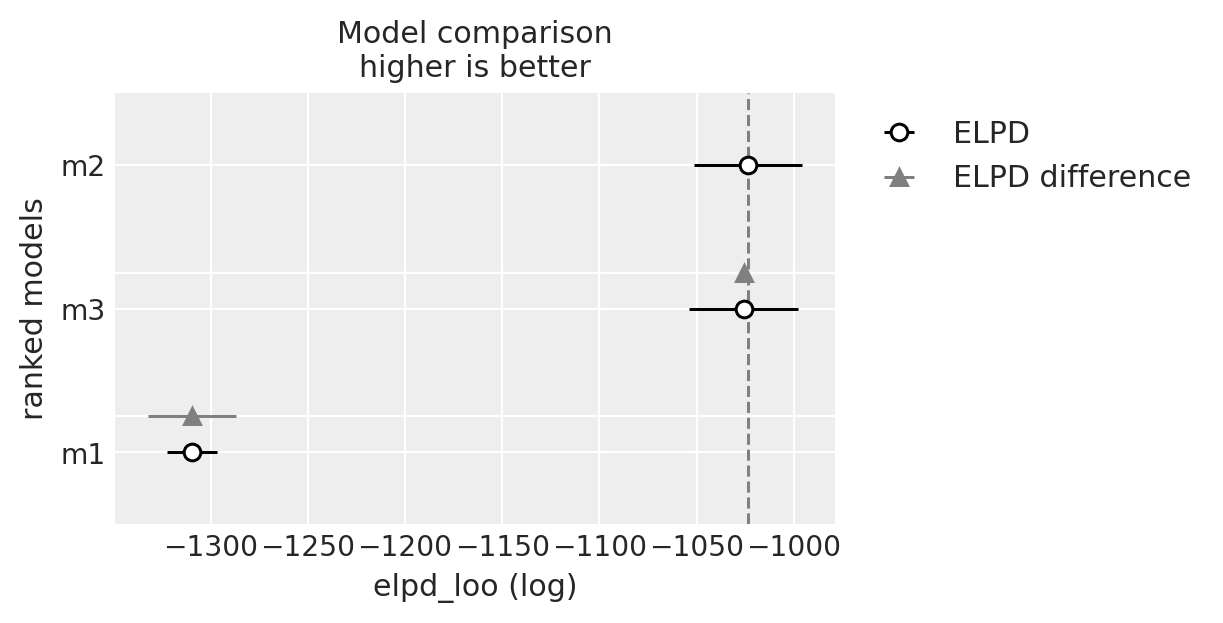

In [23]:
az.plot_compare(compare)

## Choosing Crackers over Repeated Choices: Mixed Logit Model

Moving to another example, we see a choice scenario where the same individual has been repeatedly polled on their choice of crackers among alternatives. This affords us the opportunity to evaluate the preferences of individuals by adding in coefficients for individuals for each product. 

In [24]:
try:
    c_df = pd.read_csv("../data/cracker_choice_short.csv")
except:
    c_df = pd.read_csv(pm.get_data("cracker_choice_short.csv"))
columns = [c for c in c_df.columns if c != "Unnamed: 0"]
c_df[columns]

personId  disp.sunshine  disp.keebler  disp.nabisco  disp.private  \
0            1              0             0             0             0   
1            1              1             0             0             0   
2            1              0             0             0             0   
3            1              0             0             0             0   
4            1              0             0             0             0   
...        ...            ...           ...           ...           ...   
3151       136              0             0             0             0   
3152       136              0             0             0             1   
3153       136              0             0             0             0   
3154       136              0             0             0             0   
3155       136              0             0             0             0   

      feat.sunshine  feat.keebler  feat.nabisco  feat.private  price.sunshine  \
0                 0             0             0             0            0.99   
1                 0             0             0             0            0.49   
2                 0             0             0             0            1.03   
3                 0             0             0             0            1.09   
4                 0             0             0             0            0.89   
...             ...           ...           ...           ...             ...   
3151              0             0             0             0            1.09   
3152              0             0             0             0            0.78   
3153              0             0             0             0            1.09   
3154              0             0             0             0            1.09   
3155              0             0             0             0            1.29   

      price.keebler  price.nabisco  price.private    choice lastChoice  \
0              1.09           0.99           0.71   nabisco    nabisco   
1              1.09           1.09           0.78  sunshine    nabisco   
2              1.09           0.89           0.78   nabisco   sunshine   
3              1.09           1.19           0.64   nabisco    nabisco   
4              1.09           1.19           0.84   nabisco    nabisco   
...             ...            ...            ...       ...        ...   
3151           1.19           0.99           0.55   private    private   
3152           1.35           1.04           0.65   private    private   
3153           1.17           1.29           0.59   private    private   
3154           1.22           1.29           0.59   private    private   
3155           1.04           1.23           0.59   private    private   

      personChoiceId  choiceId  
0                  1         1  
1                  2         2  
2                  3         3  
3                  4         4  
4                  5         5  
...              ...       ...  
3151               9      3152  
3152              10      3153  
3153              11      3154  
3154              12      3155  
3155              13      3156  

[3156 rows x 17 columns]

In [25]:
c_df.groupby("personId")[["choiceId"]].count().T

personId  1    2    3    4    5    6    7    8    9    10   ...  127  128  \
choiceId   15   15   13   28   13   27   16   25   18   40  ...   17   25   

personId  129  130  131  132  133  134  135  136  
choiceId   31   31   29   21   26   13   14   13  

[1 rows x 136 columns]

The presence of repeated choice over time complicates the issue. We now have to contend with issues of personal taste and the evolving or dynamic effects of pricing in a competitive environment. Plotting the simple linear and polynomial fits for each person's successive exposure to the brand price, seems to suggest that (a) pricing differentiates the product offering and (b) pricing evolves over time. 

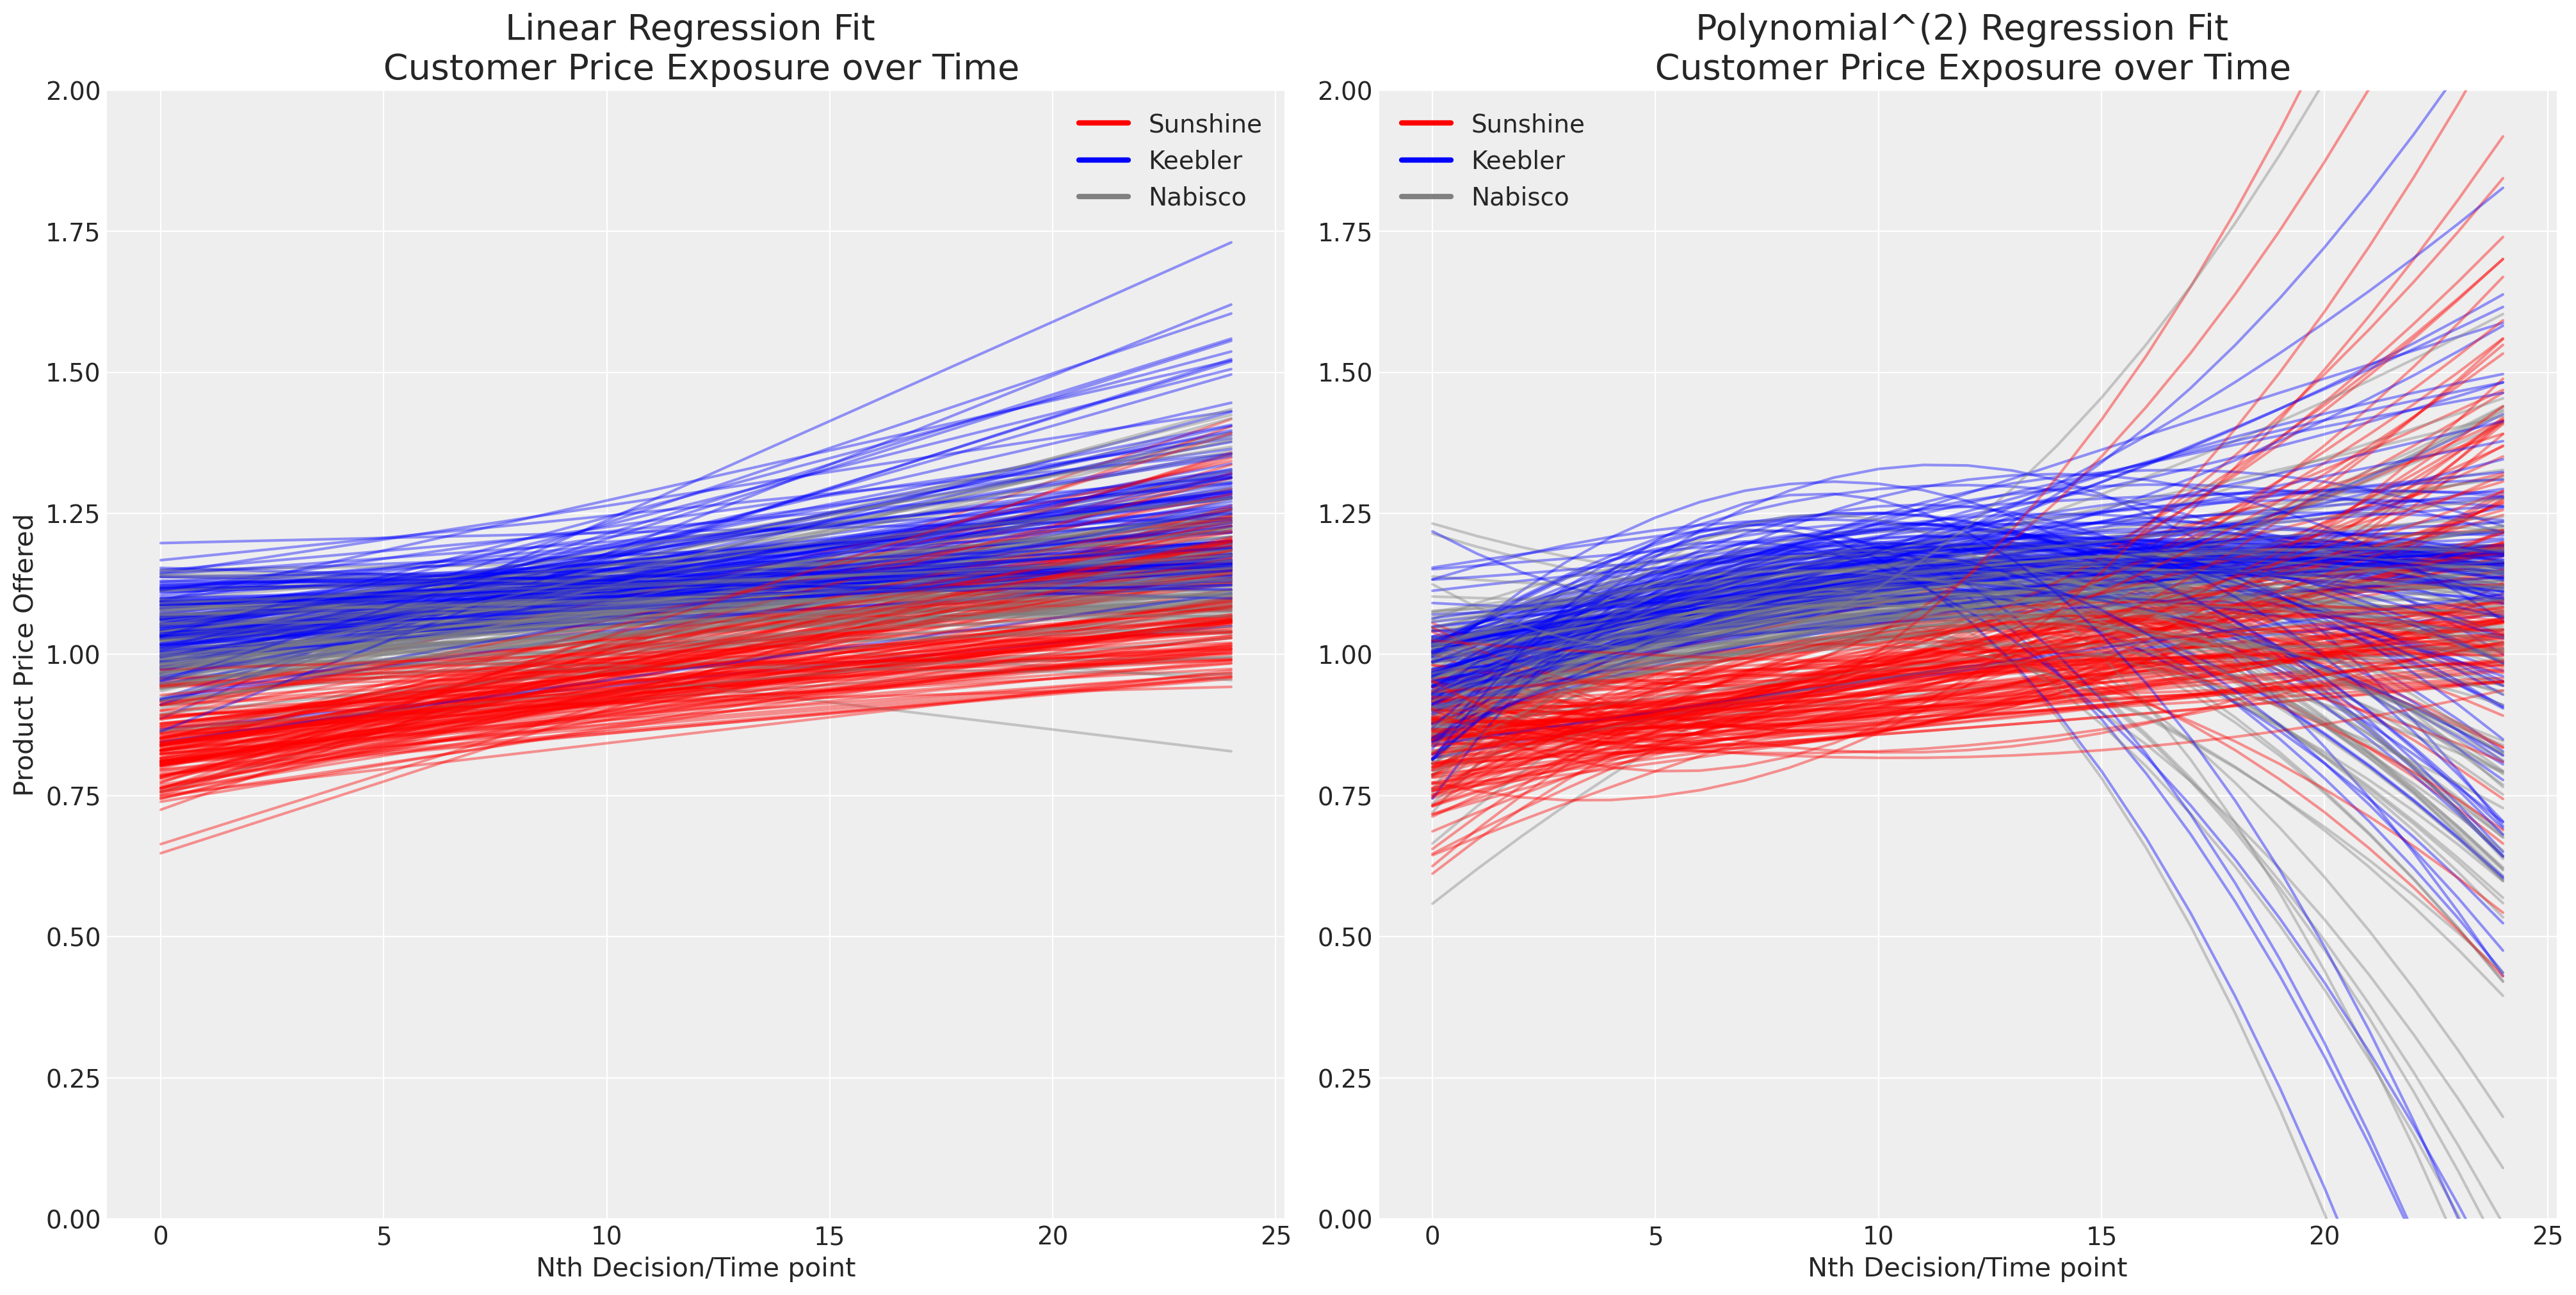

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()
map_color = {"nabisco": "red", "keebler": "blue", "sunshine": "purple", "private": "orange"}


for i in c_df["personId"].unique():
    temp = c_df[c_df["personId"] == i].copy(deep=True)
    temp["color"] = temp["choice"].map(map_color)
    predict = np.poly1d(np.polyfit(temp["personChoiceId"], temp["price.sunshine"], deg=1))
    axs[0].plot(predict(range(25)), color="red", label="Sunshine", alpha=0.4)
    predict = np.poly1d(np.polyfit(temp["personChoiceId"], temp["price.keebler"], deg=1))
    axs[0].plot(predict(range(25)), color="blue", label="Keebler", alpha=0.4)
    predict = np.poly1d(np.polyfit(temp["personChoiceId"], temp["price.nabisco"], deg=1))
    axs[0].plot(predict(range(25)), color="grey", label="Nabisco", alpha=0.4)

    predict = np.poly1d(np.polyfit(temp["personChoiceId"], temp["price.sunshine"], deg=2))
    axs[1].plot(predict(range(25)), color="red", label="Sunshine", alpha=0.4)
    predict = np.poly1d(np.polyfit(temp["personChoiceId"], temp["price.keebler"], deg=2))
    axs[1].plot(predict(range(25)), color="blue", label="Keebler", alpha=0.4)
    predict = np.poly1d(np.polyfit(temp["personChoiceId"], temp["price.nabisco"], deg=2))
    axs[1].plot(predict(range(25)), color="grey", label="Nabisco", alpha=0.4)

axs[0].set_title("Linear Regression Fit \n Customer Price Exposure over Time", fontsize=20)
axs[1].set_title("Polynomial^(2) Regression Fit \n Customer Price Exposure over Time", fontsize=20)
axs[0].set_xlabel("Nth Decision/Time point")
axs[1].set_xlabel("Nth Decision/Time point")
axs[0].set_ylabel("Product Price Offered")
axs[1].set_ylim(0, 2)
axs[0].set_ylim(0, 2)

colors = ["red", "blue", "grey"]
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle="-") for c in colors]
labels = ["Sunshine", "Keebler", "Nabisco"]
axs[0].legend(lines, labels)
axs[1].legend(lines, labels);

We'll model now how individual taste enters into discrete choice problems, but ignore the complexities of the time-dimension or the endogenity of price in the system. There are adaptions of the basic discrete choice model that are designed to address each of these complications. We'll leave the temporal dynamics as a suggested exercise for the reader. 

Sampling: [alpha, beta_disp, beta_feat, beta_individual, beta_price, y_cat]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.628050
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:11.040460
Transforming variables...
Transformation time =  0:00:01.419801
Computing Log Likelihood...


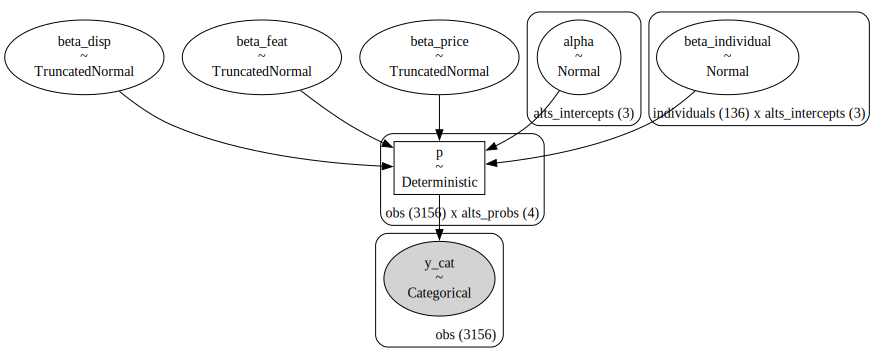

In [27]:
N = c_df.shape[0]
observed = pd.Categorical(c_df["choice"]).codes
person_indx, uniques = pd.factorize(c_df["personId"])

coords = {
    "alts_intercepts": ["sunshine", "keebler", "nabisco"],
    "alts_probs": ["sunshine", "keebler", "nabisco", "private"],
    "individuals": uniques,
    "obs": range(N),
}
with pm.Model(coords=coords) as model_4:
    beta_feat = pm.TruncatedNormal("beta_feat", 0, 1, upper=10, lower=0)
    beta_disp = pm.TruncatedNormal("beta_disp", 0, 1, upper=10, lower=0)
    ## Stronger Prior on Price to ensure an increase in price negatively impacts utility
    beta_price = pm.TruncatedNormal("beta_price", 0, 1, upper=0, lower=-10)
    alphas = pm.Normal("alpha", 0, 1, dims="alts_intercepts")
    beta_individual = pm.Normal("beta_individual", 0, 0.05, dims=("individuals", "alts_intercepts"))

    u0 = (
        (alphas[0] + beta_individual[person_indx, 0])
        + beta_disp * c_df["disp.sunshine"]
        + beta_feat * c_df["feat.sunshine"]
        + beta_price * c_df["price.sunshine"]
    )
    u1 = (
        (alphas[1] + beta_individual[person_indx, 1])
        + beta_disp * c_df["disp.keebler"]
        + beta_feat * c_df["feat.keebler"]
        + beta_price * c_df["price.keebler"]
    )
    u2 = (
        (alphas[2] + beta_individual[person_indx, 2])
        + beta_disp * c_df["disp.nabisco"]
        + beta_feat * c_df["feat.nabisco"]
        + beta_price * c_df["price.nabisco"]
    )
    u3 = np.zeros(N)  # Outside Good
    s = pm.math.stack([u0, u1, u2, u3]).T
    # Reconstruct the total data

    ## Apply Softmax Transform
    p_ = pm.Deterministic("p", pm.math.softmax(s, axis=1), dims=("obs", "alts_probs"))

    ## Likelihood
    choice_obs = pm.Categorical("y_cat", p=p_, observed=observed, dims="obs")

    idata_m4 = pm.sample_prior_predictive()
    idata_m4.extend(
        pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}, random_seed=103)
    )
    idata_m4.extend(pm.sample_posterior_predictive(idata_m4))


pm.model_to_graphviz(model_4)

In [28]:
az.summary(idata_m4, var_names=["beta_disp", "beta_feat", "beta_price", "alpha", "beta_individual"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
beta_disp                       0.023  0.021   0.000    0.061      0.000   
beta_feat                       0.019  0.018   0.000    0.052      0.000   
beta_price                     -0.021  0.020  -0.059   -0.000      0.000   
alpha[sunshine]                -0.054  0.096  -0.243    0.119      0.002   
alpha[keebler]                  2.023  0.073   1.886    2.159      0.001   
...                               ...    ...     ...      ...        ...   
beta_individual[135, keebler]   0.012  0.048  -0.077    0.104      0.000   
beta_individual[135, nabisco]  -0.009  0.051  -0.108    0.081      0.000   
beta_individual[136, sunshine] -0.002  0.049  -0.089    0.096      0.001   
beta_individual[136, keebler]  -0.018  0.048  -0.112    0.071      0.001   
beta_individual[136, nabisco]   0.020  0.050  -0.072    0.114      0.001   

                                mcse_sd  ess_bulk  ess_tail  r_hat  
beta_disp                         0.000    5386.0    2248.0    1.0  
beta_feat                         0.000    6417.0    2283.0    1.0  
beta_price                        0.000    4281.0    2277.0    1.0  
alpha[sunshine]                   0.001    3632.0    3220.0    1.0  
alpha[keebler]                    0.001    3302.0    2894.0    1.0  
...                                 ...       ...       ...    ...  
beta_individual[135, keebler]     0.001   10419.0    3135.0    1.0  
beta_individual[135, nabisco]     0.001   10504.0    2555.0    1.0  
beta_individual[136, sunshine]    0.001    7867.0    2729.0    1.0  
beta_individual[136, keebler]     0.001    7684.0    2845.0    1.0  
beta_individual[136, nabisco]     0.001    8252.0    2559.0    1.0  

[414 rows x 9 columns]

What have we learned? We've imposed a negative slope on the price coefficient but given it a wide prior. We can see that the data is sufficient to have narrowed the likely range of the coefficient considerably. 

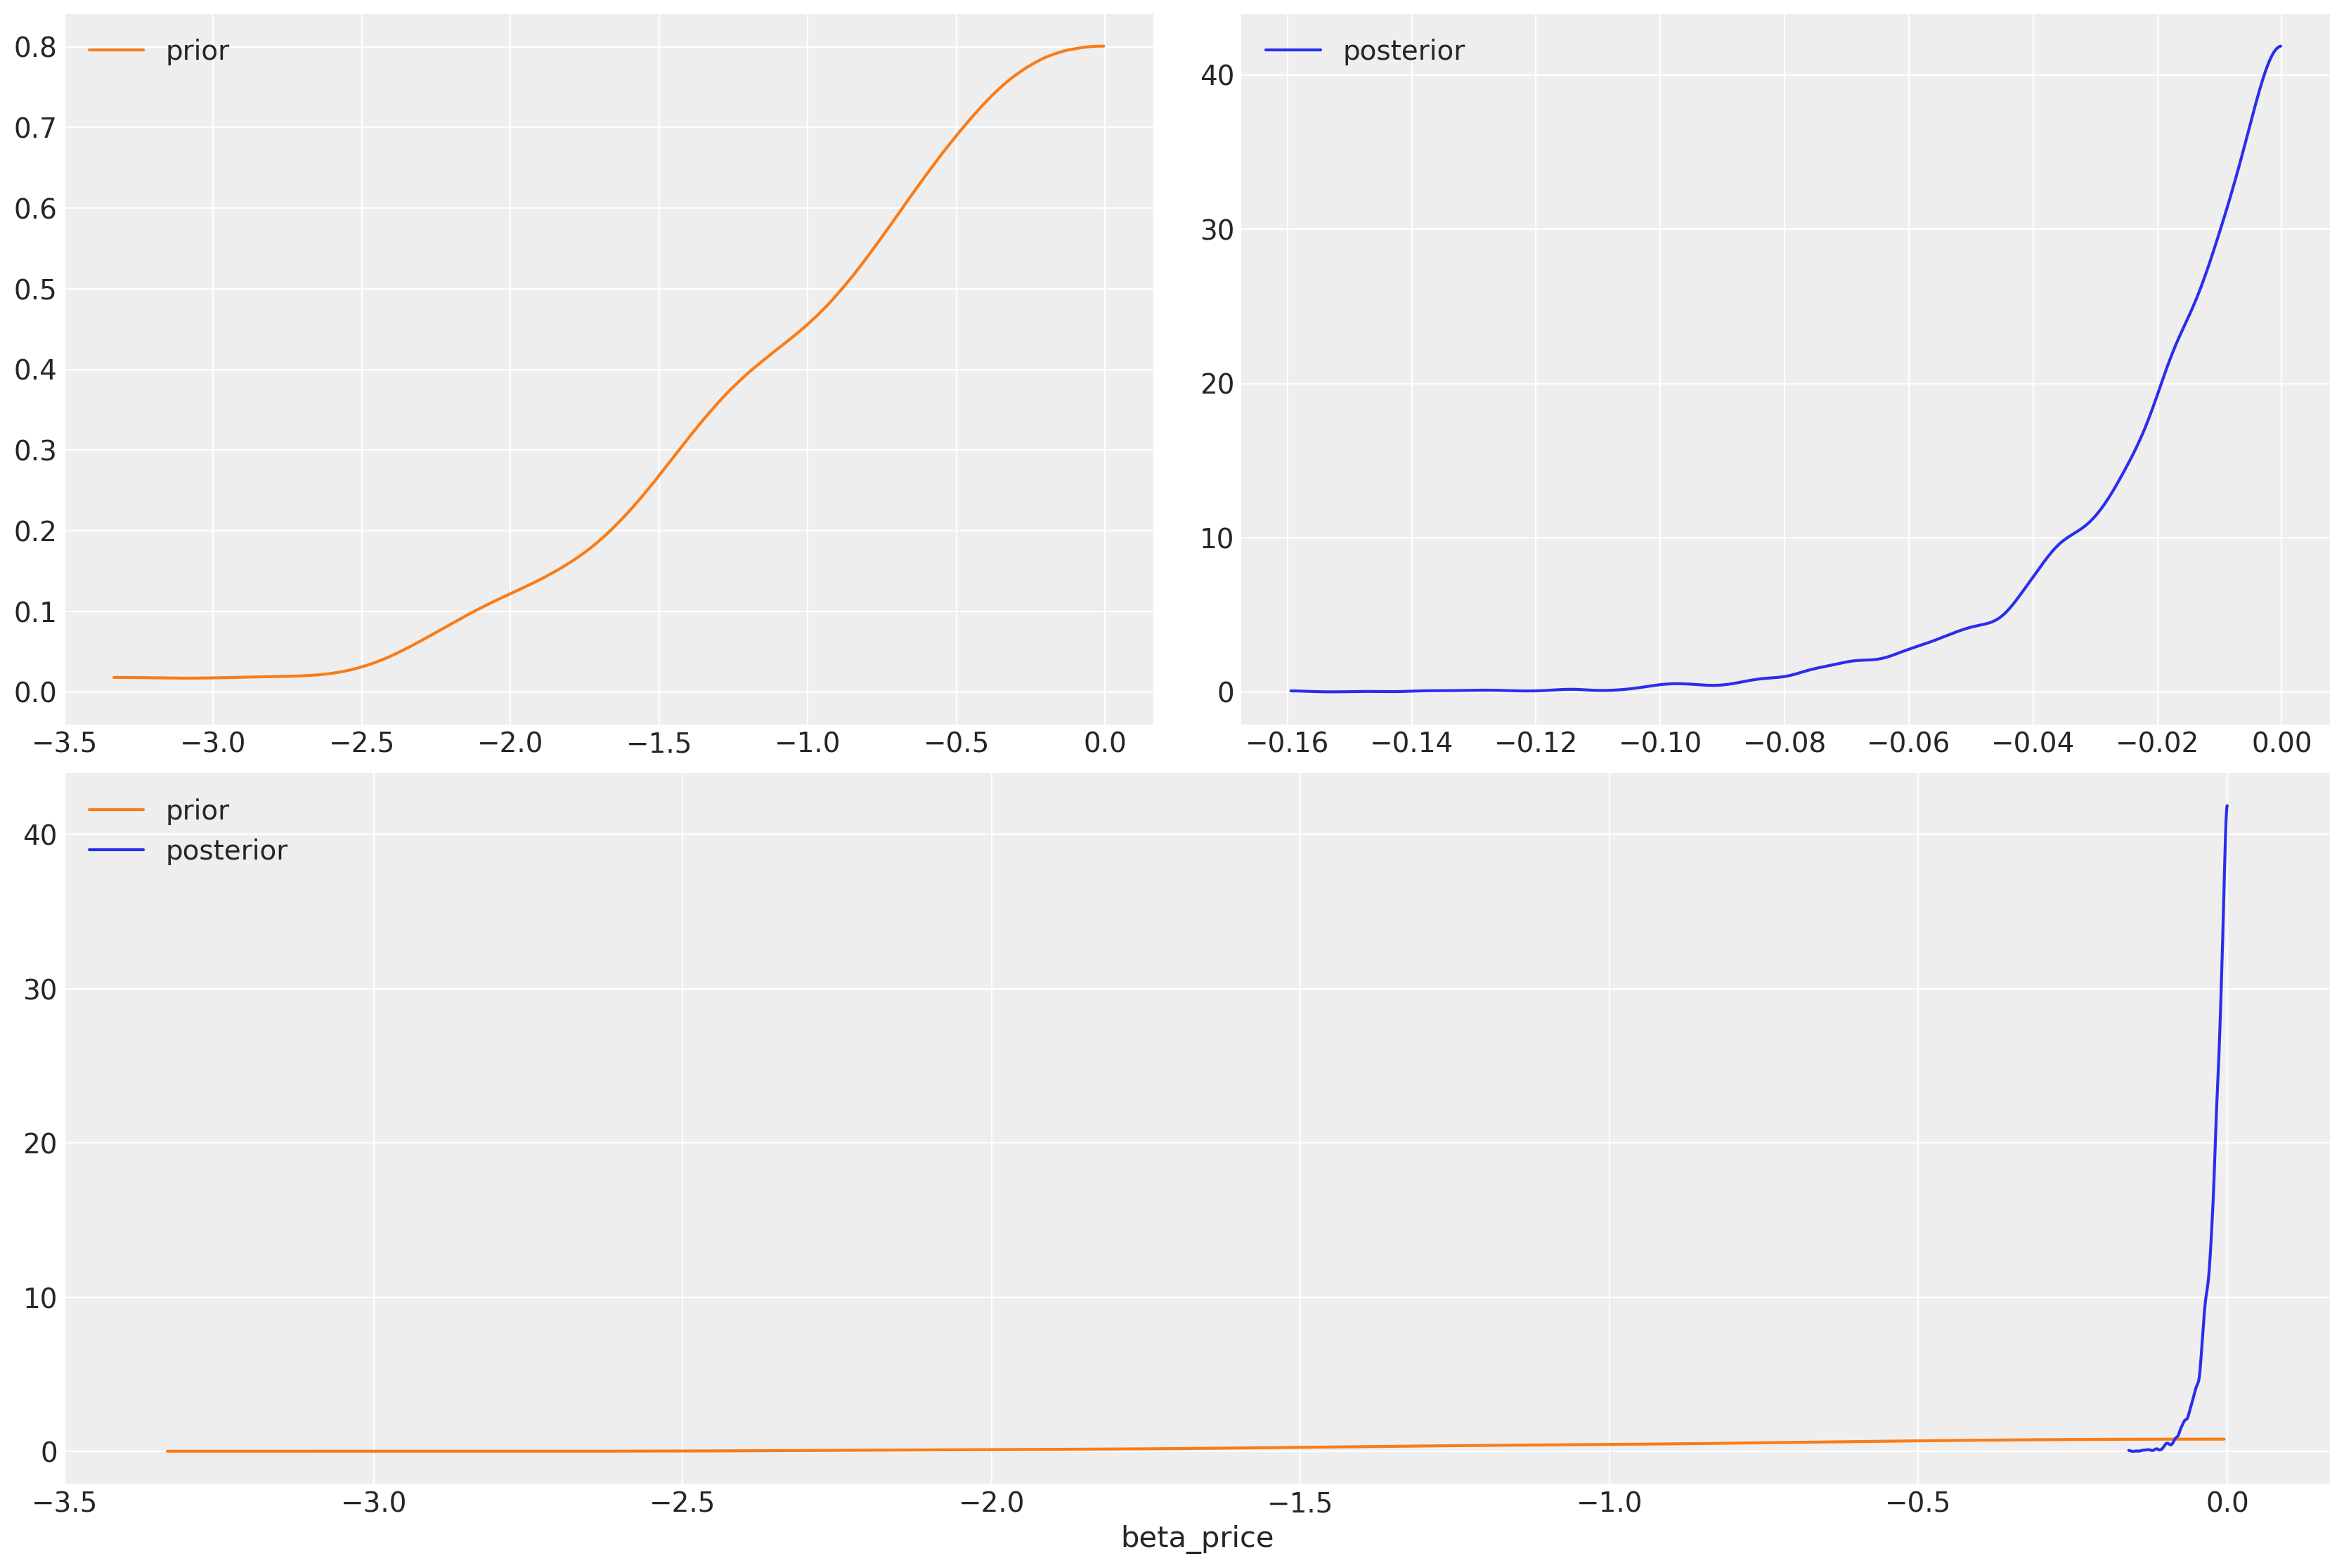

In [29]:
az.plot_dist_comparison(idata_m4, var_names=["beta_price"]);

We have explicitly set a negative prior on price and recovered a parameter specification more in line with the basic theory of rational choice. The effect of price should have a negative impact on utility. The flexibility of priors here is key for incorporating theoretical knowledge about the process involved in choice. Priors are important for building a better picture of the decision making process and we'd be foolish to ignore their value in this setting. 

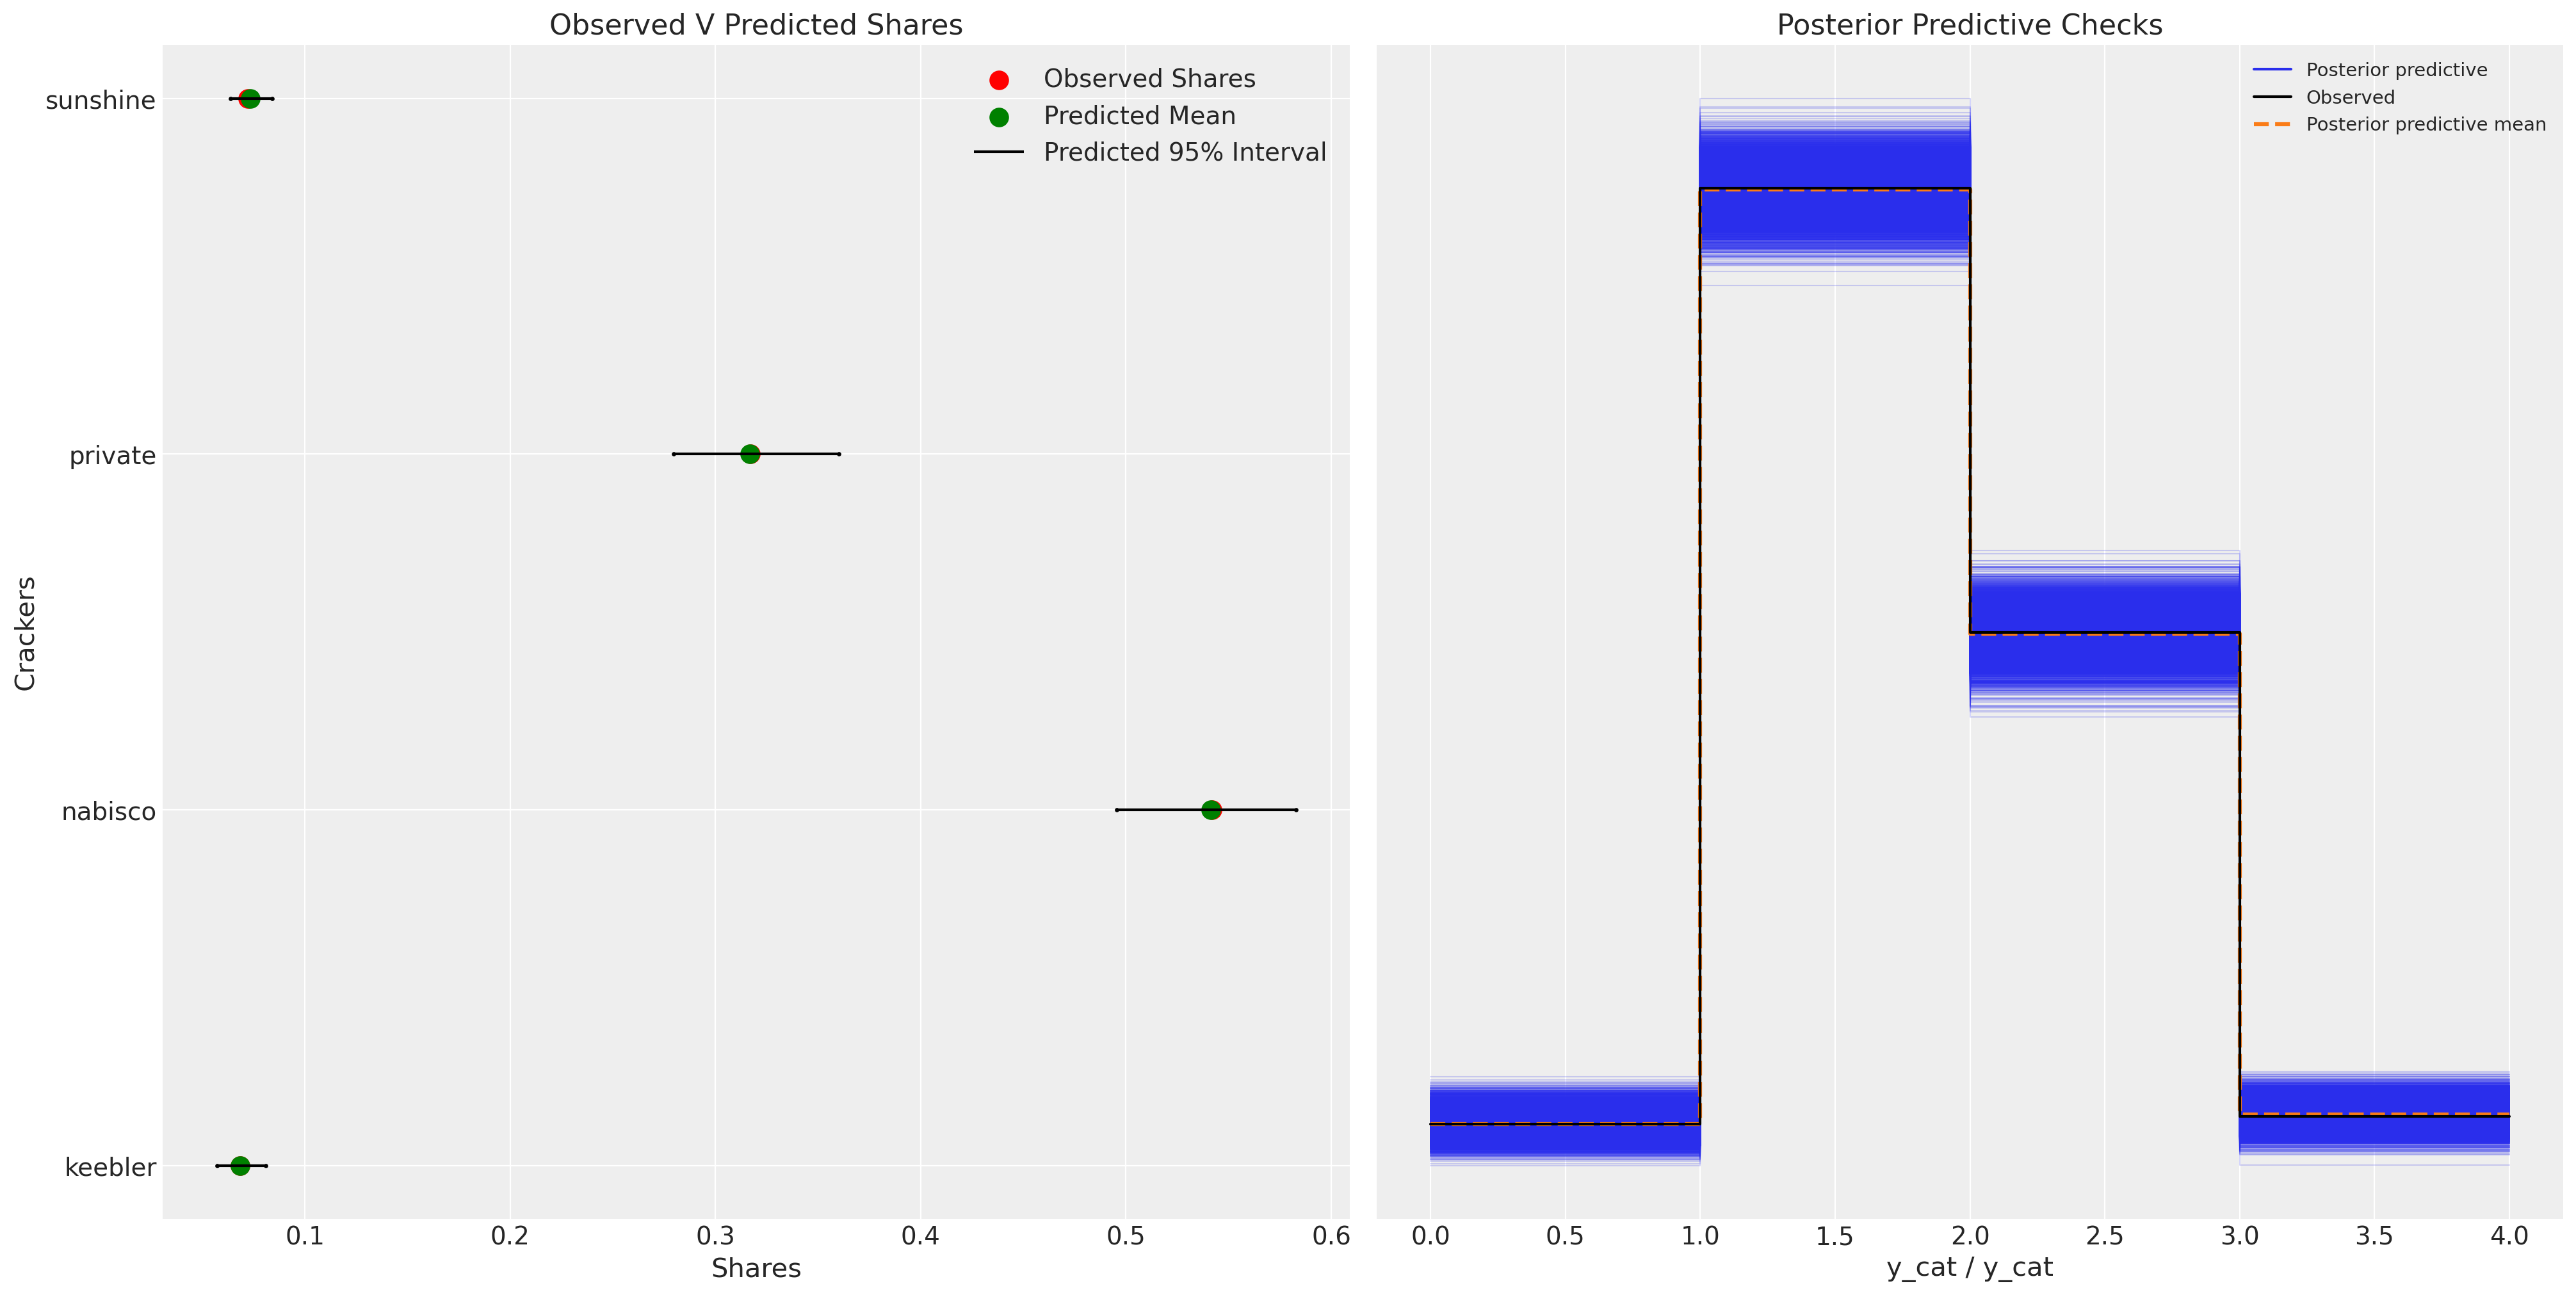

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax = axs[0]
counts = c_df.groupby("choice")["choiceId"].count()
labels = c_df.groupby("choice")["choiceId"].count().index
predicted_shares = idata_m4["posterior"]["p"].mean(dim=["chain", "draw", "obs"])
ci_lb = idata_m4["posterior"]["p"].quantile(0.025, dim=["chain", "draw", "obs"])
ci_ub = idata_m4["posterior"]["p"].quantile(0.975, dim=["chain", "draw", "obs"])
ax.scatter(ci_lb, labels, color="k", s=2)
ax.scatter(ci_ub, labels, color="k", s=2)
ax.scatter(
    counts / counts.sum(),
    labels,
    label="Observed Shares",
    color="red",
    s=100,
)
ax.scatter(
    predicted_shares,
    labels,
    label="Predicted Mean",
    color="green",
    s=100,
)
ax.hlines(
    labels,
    ci_lb,
    ci_ub,
    label="Predicted 95% Interval",
    color="black",
)
ax.legend()
ax.set_title("Observed V Predicted Shares")
az.plot_ppc(idata_m4, ax=axs[1])
axs[1].set_title("Posterior Predictive Checks")
ax.set_xlabel("Shares")
ax.set_ylabel("Crackers");

We can now also recover the differences among individuals estimated by the model for particular cracker choices. More precisely we'll plot how the individual specific contribution to the intercept drives preferences among the cracker choices. 

In [31]:
idata_m4

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [32]:
beta_individual = idata_m4["posterior"]["beta_individual"]
predicted = beta_individual.mean(("chain", "draw"))
predicted = predicted.sortby(predicted.sel(alts_intercepts="nabisco"))
ci_lb = beta_individual.quantile(0.025, ("chain", "draw")).sortby(
    predicted.sel(alts_intercepts="nabisco")
)
ci_ub = beta_individual.quantile(0.975, ("chain", "draw")).sortby(
    predicted.sel(alts_intercepts="nabisco")
)

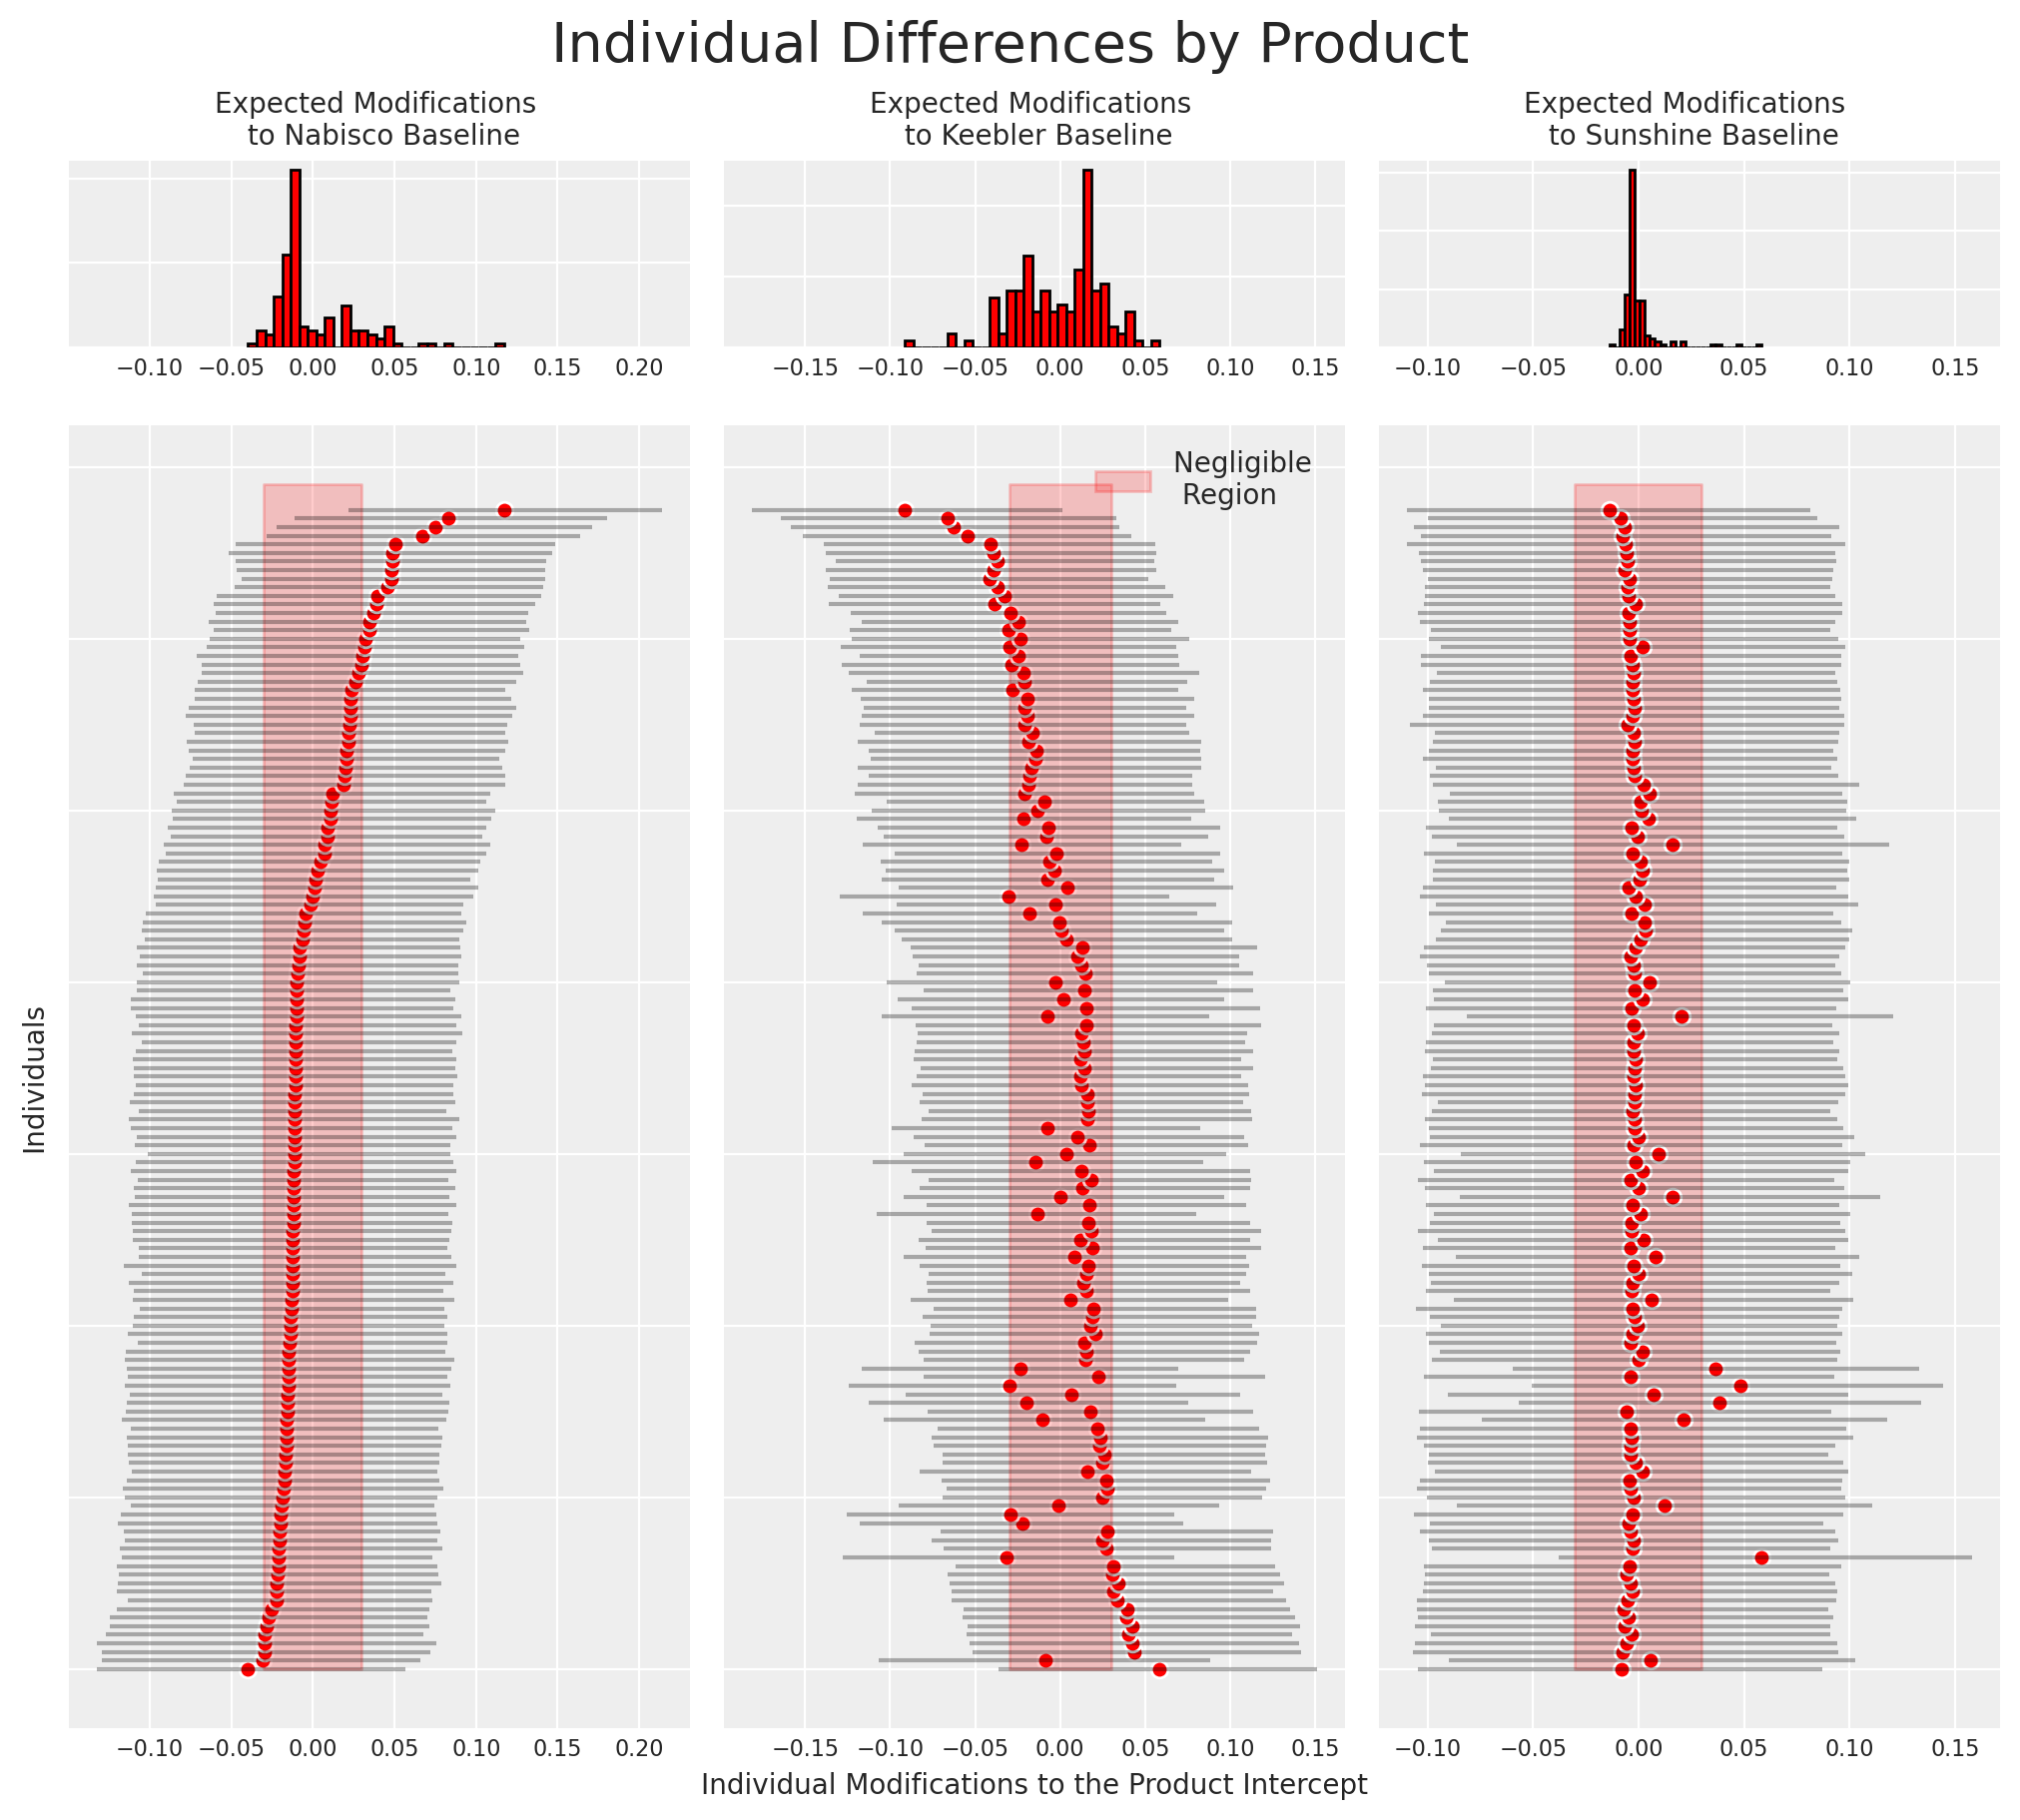

In [33]:
fig = plt.figure(figsize=(10, 9))
gs = fig.add_gridspec(
    2,
    3,
    width_ratios=(4, 4, 4),
    height_ratios=(1, 7),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.05,
    hspace=0.05,
)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax.set_yticklabels([])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histx.set_title("Expected Modifications \n to Nabisco Baseline", fontsize=10)
ax_histx.hist(predicted.sel(alts_intercepts="nabisco"), bins=30, ec="black", color="red")
ax_histx.set_yticklabels([])
ax_histx.tick_params(labelsize=8)
ax.set_ylabel("Individuals", fontsize=10)
ax.tick_params(labelsize=8)
ax.hlines(
    range(len(predicted)),
    ci_lb.sel(alts_intercepts="nabisco"),
    ci_ub.sel(alts_intercepts="nabisco"),
    color="black",
    alpha=0.3,
)
ax.scatter(predicted.sel(alts_intercepts="nabisco"), range(len(predicted)), color="red", ec="white")
ax.fill_betweenx(range(139), -0.03, 0.03, alpha=0.2, color="red")

ax1 = fig.add_subplot(gs[1, 1])
ax1.set_yticklabels([])
ax_histx = fig.add_subplot(gs[0, 1], sharex=ax1)
ax_histx.set_title("Expected Modifications \n to Keebler Baseline", fontsize=10)
ax_histx.set_yticklabels([])
ax_histx.tick_params(labelsize=8)
ax_histx.hist(predicted.sel(alts_intercepts="keebler"), bins=30, ec="black", color="red")
ax1.hlines(
    range(len(predicted)),
    ci_lb.sel(alts_intercepts="keebler"),
    ci_ub.sel(alts_intercepts="keebler"),
    color="black",
    alpha=0.3,
)
ax1.scatter(
    predicted.sel(alts_intercepts="keebler"), range(len(predicted)), color="red", ec="white"
)
ax1.set_xlabel("Individual Modifications to the Product Intercept", fontsize=10)
ax1.fill_betweenx(range(139), -0.03, 0.03, alpha=0.2, color="red", label="Negligible \n Region")
ax1.tick_params(labelsize=8)
ax1.legend(fontsize=10)

ax2 = fig.add_subplot(gs[1, 2])
ax2.set_yticklabels([])
ax_histx = fig.add_subplot(gs[0, 2], sharex=ax2)
ax_histx.set_title("Expected Modifications \n to Sunshine Baseline", fontsize=10)
ax_histx.set_yticklabels([])
ax_histx.hist(predicted.sel(alts_intercepts="sunshine"), bins=30, ec="black", color="red")
ax2.hlines(
    range(len(predicted)),
    ci_lb.sel(alts_intercepts="sunshine"),
    ci_ub.sel(alts_intercepts="sunshine"),
    color="black",
    alpha=0.3,
)
ax2.fill_betweenx(range(139), -0.03, 0.03, alpha=0.2, color="red")
ax2.scatter(
    predicted.sel(alts_intercepts="sunshine"), range(len(predicted)), color="red", ec="white"
)
ax2.tick_params(labelsize=8)
ax_histx.tick_params(labelsize=8)
plt.suptitle("Individual Differences by Product", fontsize=20);

This type of plot is often useful for identifying loyal customers. Similarly it can be used to identify cohorts of customers that ought to be better incentivised if we hope them to switch to our product.

## Conclusion

We can see here the flexibility and richly parameterised possibilities for modelling individual choice of discrete options. These techniques are useful in a wide variety of domains from microeconomics, to marketing and product development. The notions of utility, probability and their interaction lie at the heart of [Savage's Representation theorem](https://plato.stanford.edu/entries/decision-theory/) and justification(s) for Bayesian approaches to statistical inference. So discrete modelling is a natural fit for the Bayesian, but Bayesian statistics is also a natural fit for discrete choice modelling. The traditional estimation techniques are often brittle and very dependent on starting values of the MLE process. The Bayesian setting trades this brittleness for a framework which allows us to incorporate our beliefs about what drives human utility calculations. We've only scratched the surface in this example notebook, but encourage you to further explore the technique. 



## Authors
- Authored by [Nathaniel Forde](https://nathanielf.github.io/) in June 2023 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [34]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Thu Jul 13 2023

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.11.0

pytensor: 2.11.1

numpy     : 1.23.5
matplotlib: 3.7.1
pytensor  : 2.11.1
pandas    : 1.5.3
arviz     : 0.15.1
pymc      : 5.3.0

Watermark: 2.3.1



:::{include} ../page_footer.md
:::